# Module 2 Final Project Submission
- Student: James M. Irving, Ph.D.
- Github Link: https://github.com/jirvingphd/dsc-2-final-project-online-ds-ft-021119 
- Reviewer: Jeff Herman
- Review Date: 04/08/19
- Blog Post:

In [1]:
# Note: By default, the notebook will not save figures and csv files
# Change save_for_user to True in order to save outputs. 
save_for_user = False 
fig_filepath = "Figures/"
data_filepath = "Exported CSV/"

___

# Importing of Packages and Defining Functions

### If running on CoLab, uncomment the cell below:

In [2]:
# # If running on googe colab
# # #CELL A : IF ON COLAB.
# # #The northwind.sqlite is located in: content/drive/My Drive/Colab Notebooks/datasets/Northwind_small.sqlite
# from google.colab import drive
# drive.mount('/content/drive/', force_remount=True)

# # # If in Google Drive 
# path= '/content/drive/My Drive/Colab Notebooks/datasets/'
# file='Northwind_small.sqlite'
# filepath = path+file
# # filepath = '/content/drive/My Drive/Colab Notebooks/datasets/Northwind_small.sqlite'
# #NOTE: To save files to drive, just to df.to_csv(path+'filename.csv')

# If local:
filepath = 'Northwind_small.sqlite'

## Import packages:

In [3]:
# Normal packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline

# Statsmodels

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

import scipy.stats as stats


# Counter
from collections import Counter

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
import sklearn.metrics as metrics


import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.orm import Session, sessionmaker
from sqlalchemy import inspect

## Defining Functions

### def check_column

In [4]:
# Check columns returns the datatype, null values and unique values of input series 
def check_column(series,nlargest='all'):
    print(f"Column: df['{series.name}']':")
    print(f"dtype: {series.dtype}")
    print(f"isna: {series.isna().sum()} out of {len(series)} - {round(series.isna().sum()/len(series)*100,3)}%")
        
    print(f'\nUnique non-na values:') #,df['waterfront'].unique())
    if nlargest =='all':
        print(series.value_counts())
    else:
        print(series.value_counts().nlargest(nlargest))

### def detect_outliers

In [5]:
# Tukey's method using IQR to eliminate 
def detect_outliers(df, n, features):
    """Uses Tukey's method to return outer of interquartile ranges to return indices if outliers in a dataframe.
    Parameters:
    df (DataFrame): DataFrane containing columns of features
    n: default is 0, multiple outlier cutoff  
    
    Returns:
    Index of outliers for .loc
    
    Examples:
    Outliers_to_drop = detect_outliers(data,2,["col1","col2"]) Returning value
    df.loc[Outliers_to_drop] # Show the outliers rows
    data= data.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)
   """

# Drop outliers    

    outlier_indices = []
    # iterate over features(columns)
    for col in features:
        
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) 
                              | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
        # select observations containing more than 2 outliers
        outlier_indices = Counter(outlier_indices)        
        multiple_outliers = list( k for k,v in
                                 outlier_indices.items() if v > n )
    return multiple_outliers 


### def plot_hist_scat_sns

In [6]:
# Plots histogram and scatter (vs price) side by side
def plot_hist_scat_sns(df, target='index'):
    """Plots seaborne distplots and regplots for columns im datamframe vs target.

    Parameters:
    df (DataFrame): DataFrame.describe() columns will be used. 
    target = name of column containing target variable.assume first coluumn. 
    
    Returns:
    Figures for each column vs target with 2 subplots.
   """
    import matplotlib.ticker as mtick
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    with plt.style.context(('dark_background')):
        ###  DEFINE AESTHETIC CUSTOMIZATIONS  -------------------------------##


#         plt.style.use('dark_background')
        figsize=(9,7)

        # Axis Label fonts
        fontTitle = {'fontsize': 14,
                   'fontweight': 'bold',
                    'fontfamily':'serif'}

        fontAxis = {'fontsize': 12,
                   'fontweight': 'medium',
                    'fontfamily':'serif'}

        fontTicks = {'fontsize': 8,
                   'fontweight':'medium',
                    'fontfamily':'serif'}

        # Formatting dollar sign labels
        fmtPrice = '${x:,.0f}'
        tickPrice = mtick.StrMethodFormatter(fmtPrice)


        ###  PLOTTING ----------------------------- ------------------------ ##

        # Loop through dataframe to plot
        for column in df.describe():
#             print(f'\nCurrent column: {column}')

            # Create figure with subplots for current column
            fig, ax = plt.subplots(figsize=figsize, ncols=2, nrows=2)

            ##  SUBPLOT 1 --------------------------------------------------##
            i,j = 0,0
            ax[i,j].set_title(column.capitalize(),fontdict=fontTitle)

            # Define graphing keyword dictionaries for distplot (Subplot 1)
            hist_kws = {"linewidth": 1, "alpha": 1, "color": 'blue','edgecolor':'w'}
            kde_kws = {"color": "white", "linewidth": 1, "label": "KDE"}

            # Plot distplot on ax[i,j] using hist_kws and kde_kws
            sns.distplot(df[column], norm_hist=True, kde=True,
                         hist_kws = hist_kws, kde_kws = kde_kws,
                         label=column+' histogram', ax=ax[i,j])


            # Set x axis label
            ax[i,j].set_xlabel(column.title(),fontdict=fontAxis)

            # Get x-ticks, rotate labels, and return
            xticklab1 = ax[i,j].get_xticklabels(which = 'both')
            ax[i,j].set_xticklabels(labels=xticklab1, fontdict=fontTicks, rotation=0)
            ax[i,j].xaxis.set_major_formatter(mtick.ScalarFormatter())


            # Set y-label 
            ax[i,j].set_ylabel('Density',fontdict=fontAxis)
            yticklab1=ax[i,j].get_yticklabels(which='both')
            ax[i,j].set_yticklabels(labels=yticklab1,fontdict=fontTicks)
            ax[i,j].yaxis.set_major_formatter(mtick.ScalarFormatter())


            # Set y-grid
            ax[i, j].set_axisbelow(True)
            ax[i, j].grid(axis='y',ls='--')




            ##  SUBPLOT 2-------------------------------------------------- ##
            i,j = 0,1
            ax[i,j].set_title(column.capitalize(),fontdict=fontTitle)

            # Define the kwd dictionaries for scatter and regression line (subplot 2)
            line_kws={"color":"white","alpha":0.5,"lw":4,"ls":":"}
            scatter_kws={'s': 2, 'alpha': 0.5,'marker':'.','color':'blue'}

            # Plot regplot on ax[i,j] using line_kws and scatter_kws
            sns.regplot(df[column], df[target], 
                        line_kws = line_kws,
                        scatter_kws = scatter_kws,
                        ax=ax[i,j])

            # Set x-axis label
            ax[i,j].set_xlabel(column.title(),fontdict=fontAxis)

             # Get x ticks, rotate labels, and return
            xticklab2=ax[i,j].get_xticklabels(which='both')
            ax[i,j].set_xticklabels(labels=xticklab2,fontdict=fontTicks, rotation=0)
            ax[i,j].xaxis.set_major_formatter(mtick.ScalarFormatter())

            # Set  y-axis label
            ax[i,j].set_ylabel(target,fontdict=fontAxis)

            # Get, set, and format y-axis Price labels
            yticklab = ax[i,j].get_yticklabels()
            ax[i,j].set_yticklabels(yticklab,fontdict=fontTicks)
            ax[i,j].yaxis.set_major_formatter(mtick.ScalarFormatter())

    #         ax[i,j].get_yaxis().set_major_formatter(tickPrice) 

            # Set y-grid
            ax[i, j].set_axisbelow(True)
            ax[i, j].grid(axis='y',ls='--')       

            ## ---------- Final layout adjustments ----------- ##
            # Deleted unused subplots 
            fig.delaxes(ax[1,1])
            fig.delaxes(ax[1,0])

            # Optimizing spatial layout
            fig.tight_layout()
            figtitle=column+'_dist_regr_plots.png'
#             plt.savefig(figtitle)
    return 

### def plot_wide_kde_mean_sem_bar()

In [7]:
def plot_wide_kde_thin_bar(series1,sname1, series2, sname2,**kwargs):
    '''Plot series1 and series 2 on wide kde plot with small mean+sem bar plot.
    **kwargs include:
        title_var -- the variable that will appear in the title of both graphs. 
    '''
    
    ## ADDING add_gridspec usage
    import pandas as pd
    import numpy as np
    from scipy.stats import sem

    import matplotlib.pyplot as plt
    import matplotlib as mpl
    import matplotlib.ticker as ticker
    %matplotlib inline

    import seaborn as sns

    from matplotlib import rcParams
    from matplotlib import rc
#     mpl.rcdefaults()
#     rcParams['font.family'] = 'serif'
#     rcParams['hatch.color'] = 'gray'
#     plt.rcParams["axes.edgecolor"] = "black"
    mpl.rcParams['hatch.linewidth'] = 0.5
    
    title=series1.name
    for k,v in kwargs.items():
        if k.lower() == 'title_var':
            title = v.title()

    # Plot distributions of discounted vs full price groups
#     plt.style.use('default')
    # with plt.style.context(('tableau-colorblind10')):
    with plt.style.context(('dark_background')):

        

        ## ----------- DEFINE AESTHETIC CUSTOMIZATIONS ----------- ##
       # Axis Label fonts
        fontSuptitle ={'fontsize': 16,
                   'fontweight': 'bold',
                    'fontfamily':'serif'}

        fontTitle = {'fontsize': 14,
                   'fontweight': 'medium',
                    'fontfamily':'serif'}

        fontAxis = {'fontsize': 12,
                   'fontweight': 'medium',
                    'fontfamily':'serif'}

        fontTicks = {'fontsize': 10,
                   'fontweight':'medium', 
                    'fontfamily':'serif'}


        ## --------- CREATE FIG BASED ON GRIDSPEC --------- ##
        
        plt.suptitle(title+' of Units Sold', fontdict = fontSuptitle)

        # Create fig object and declare figsize
        fig = plt.figure(constrained_layout=True, figsize=(10,5))
        
        
        # Define gridspec to create grid coordinates             
        gs = fig.add_gridspec(nrows=1,ncols=9)

        # Assign grid space to ax with add_subplot
        ax0 = fig.add_subplot(gs[0,0:7])
        ax1 = fig.add_subplot(gs[0,7:9])
        
        #Combine into 1 list
        ax = [ax0,ax1]
        
        ### ------------------  SUBPLOT 1  ------------------ ###

        ## --------- Defining series1 and 2 for subplot 1------- ##
        ax[0].set_title('Distribution of '+title,fontdict=fontTitle)

        # Group 1: data, label, hist_kws and kde_kws
        plotS1 = {'data': series1, 'label': sname1.title(),

                   'hist_kws' :
                    {'edgecolor': 'white', 'color':'darkgray','alpha': 1, 'lw':1},
                    #'hatch':'//'},

                   'kde_kws':
                    {'color':'white', 'linestyle': '-', 'linewidth':2,
                     'label':'kde'}}

        # Group 2: data, label, hist_kws and kde_kws
        plotS2 = {'data': series2,
                    'label': sname2.title(), 

                    'hist_kws' :
                    {'edgecolor': 'white','color':'lightgreen','alpha':0.8 ,'lw':1,'hatch':'//'},


                    'kde_kws':
                    {'color':'darkgreen','linestyle':'-','linewidth':2,'label':'kde'}}
        
        # plot group 1
        sns.distplot(plotS1['data'], label=plotS1['label'],
                   
                     hist_kws = plotS1['hist_kws'], kde_kws = plotS1['kde_kws'],
                     
                     ax=ax[0])   
      

        # plot group 2
        sns.distplot(plotS2['data'], label=plotS2['label'],
                     
                     hist_kws=plotS2['hist_kws'], kde_kws = plotS2['kde_kws'],
                     
                     ax=ax[0])

        # X label
        xlabel = series1.name
        xl = xlabel.replace('_',' ').title()
        ax[0].set_xlabel(xl,fontdict=fontAxis)
        ax[0].set_ylabel('Kernel Density Estimation',fontdict=fontAxis)
        # ticks/legend
        ax[0].tick_params(axis='both',labelsize=fontTicks['fontsize'])   
        ax[0].legend()

        
#         # annotating lines with means
#         meanS1 = np.mean(plotS1['data'])
#         meanS2 = np.mean(plotS2['data'])
        
#         ax[0].axvline(meanS1, linestyle='--',label=sname1)
#         ax[0].text(meanS1,0,f'Mean:{meanS1:.2f}',rotation=90)
    
#         ax[0].axvline(meanS2,color='k',linestyle='--',label=sname2)
#         ax[0].text(meanS2,0,f'Mean:{meanS2:.2f}',rotation=90)
        
        
        ### ------------------  SUBPLOT 2  ------------------ ###
        
        # Import scipy for error bars
        from scipy.stats import sem
    
        # Declare x y group labels(x) and bar heights(y)
        x = [plotS1['label'], plotS2['label']]
        y = [np.mean(plotS1['data']), np.mean(plotS2['data'])]
    
        yerr = [sem(plotS1['data']), sem(plotS2['data'])]
        err_kws = {'ecolor':'white','capsize':4,'capthick':2,'elinewidth':2}

        # Create the bar plot
        ax[1].bar(x,y, align='edge', edgecolor='white',linewidth=2, color =[plotS1['hist_kws']['color'],plotS2['hist_kws']['color']],
                  yerr=yerr,error_kw=err_kws, width=0.6,)

        
        # Customize subplot 2
        ax[1].set_title('Average '+title,fontdict=fontTitle)
        ax[1].set_ylabel('Mean +/- SEM ',fontdict=fontAxis)
        ax[1].set_xlabel('')
        
        ax[1].tick_params(axis=y,labelsize=fontTicks['fontsize'])
        ax[1].tick_params(axis=x,labelsize=fontTicks['fontsize']) 

        ax1=ax[1]
        test = ax1.get_xticklabels()
        labels = [x.get_text() for x in test]
        ax1.set_xticklabels([plotS1['label'],plotS2['label']], rotation=45,ha='center',fontdict=fontAxis)
        
        print(f"Mean of {plotS1['label']}: {np.mean(plotS1['data'])}\n Mean of {plotS2['label']}: {np.mean(plotS2['data'])}")

#         plt.tight_layout()
        plt.show()
        return fig,ax
    
    


### def list2df

In [8]:
def list2df(list):#, sort_values='index'):
    """ Take in a list where row[0] = column_names and outputs a dataframe.
    
    Keyword arguments:
    set_index -- df.set_index(set_index)
    sortby -- df.sorted()
    """    
    
    df_list = pd.DataFrame(list[1:],columns=list[0])
#     df_list = df_list[1:]

    return df_list

### def get_col_info

In [9]:
def  get_col_info(col_name):
    """Gets the column names and data types from the alchamey inspector object.
    Returns column_info dataframe of table details.
    """
    col_list = inspector.get_columns(col_name)
    
    column_info = [['table','column','dtype']]
    print(f'Table Name: {col_name}\n')

    for col in col_list:
        column_info.append([str(col_name),col['name'], col['type']])
        
    df = list2df(column_info)
    return column_info

### def describe_outliers

In [10]:
# describe_outliers -- calls detect_outliers
def describe_outliers(df):
    """ Returns a new_df of outliers, and % outliers each col using detect_outliers.
    """
    out_count = 0
    new_df = pd.DataFrame(columns=['total_outliers',
                                   'percent_total'])
    for col in df.columns:
        outies = detect_outliers(df[col])
        out_count += len(outies) 
        new_df.loc[col] = [len(outies), round((len(outies)
                                 /len(df.index))*100, 2)]
    new_df.loc['grand_total'] = [sum(new_df['total_outliers']),
                                 sum(new_df['percent_total'])]
    return new_df

### def get_full_table_info

In [11]:
def  get_full_table_info(engine):
    """Gets the table names, their column namesand data types engine.
    Returns column_info dataframe of table details.
    """
    column_info = [['table','column','dtype']]
    
    list_tables= engine.table_names()
    
    for table in list_tables:
        col_list = inspector.get_columns(table)
        
        for col in col_list:
            column_info.append([str(table),
                                col['name'],
                                col['type'],
                                col['']])
            
            inspector.get_foreign_keys()
    
    df = list2df(column_info)
    return df

### def Cohen's d 

In [12]:
#### Cohen's d
def Cohen_d(group1, group2):
    # Compute Cohen's d.
    # group1: Series or NumPy array
    # group2: Series or NumPy array
    # returns a floating point number 
    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled threshold as shown earlier
    pooled_var = ((n1 * var1 
                  + n2 * var2) 
                  / (n1 + n2))
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d


def plot_pdfs(cohen_d=2):
    """Plot PDFs for distributions that differ by some number of stds.
    
    cohen_d: number of standard deviations between the means
    """
    group1 = scipy.stats.norm(0, 1)
    group2 = scipy.stats.norm(cohen_d, 1)
    xs, ys = evaluate_PDF(group1)
    pyplot.fill_between(xs, ys,
                        label='Group1',
                        color='#ff2289', 
                        alpha=0.7)

    xs, ys = evaluate_PDF(group2)
    pyplot.fill_between(xs, ys, 
                        label='Group2', 
                        color='#376cb0', 
                        alpha=0.7)
    
    o, s = overlap_superiority(group1, group2)
    print('overlap', o)
    print('superiority', s)
   

### def calc_product_price, def calc_order_total

In [13]:
# Source of df = pd.read_sql_query("SELECT * FROM OrderDetail",  engine)

# Define calc_product_review to add product price column
def calc_product_price(row):
    '''Calculates the sub-total for the product in the row. 
    Classifies the product as OnSale or not. 
    Sub-total =  [UnitPrice*(1-Discount)*Quantity
    
    Returns:
    New columns OnSale and price'''
    
    price = (row['UnitPrice']
             *(1-row['Discount'])
             *row['Quantity'])
    
    row['price'] = price
    if row['Discount']>0:
        row['OnSale'] = 1
        
    else:
        row['OnSale'] = 0
    return row    

# Use calc_order_total to fill in order_total column
def calc_order_total(row,df):
    '''Takes in a specific row and the whole dataframe.
    Groupby OrderID. Classify as discounted_order if any
    item was on discount. 
    Returns row with added 'discounted_order' category and 
    'order_total' '''
    order = row['OrderId']
    df_temp = df.groupby('OrderId').get_group(order)

    
    if any(df_temp['OnSale']):
        row['discounted_order'] = 1
    else:
        row['discounted_order'] = 0
    
    order_total = df_temp['price'].sum()
    row['order_total'] = order_total
    
    return row

#### def quant_transform 

In [14]:
# TRANSFORM DATA BEFORE RE-CALLING ORIGINAL normtest_results
def quant_transform(data_in):
    '''Use sklearn.preprocessing.QuantileTransformer to remove outliers from dataset.
    
    Parameters:
        data_in (dict) -- dictionary with data series as values to be processed.
    Returns: 
        data_tf (dict) -- dicionary of same keys from data_in, but transformed.
        '''
    
    from sklearn import preprocessing as prep 
    from sklearn.preprocessing import QuantileTransformer

    qt =  QuantileTransformer(n_quantiles=10,output_distribution='normal')
    data_tf = {}
    for k,v in data_in.items():    
        data = np.array(v).reshape(-1,1)
        transformed = pd.Series(np.squeeze(qt.fit_transform(data)))

        data_tf[k] = transformed
    
    return data_tf

## Define plotting functions for looking at each month individually 


### def make_violinplot

In [15]:
# plotting order totals per month in violin plots

def draw_violinplot(x , y, hue=None, data=None, title=None,
                    ticklabels=None, leg_label=None):
    
    '''Plots a violin plot with horizontal mean line, inner stick lines
    y must be array like in order to plot mean line. x can be label in data'''
#     plt.style.use('dark_backm')
    
    fig,ax = plt.subplots(figsize=(12,10))

    ax = sns.violinplot(x, y, hue=hue,
                   data = data,
                   cut=2,
                   split=True, 
                   scale='count',
                   scale_hue=True,
                   saturation=.7,
                   alpha=.9, 
                   bw=.25,
                   palette='Dark2',
                   inner='stick'
                  ).set_title(title)
    
    ax.set(xlabel= x.name.title(),
           ylabel= y.name.title(),
           xticklabels=ticks)
    
    ax.axhline( y.mean(),
               label='Total Mean',
               ls=':',
               alpha=.2, 
               color='xkcd:yellow')
    
    ax.legend().set_title(leg_label)

    plt.show()
    return fig, ax

### def make-stripplot

In [16]:
def make_stripplot(x, y, title=None, hue=None, ticklabels=None):

    with plt.style.context('dark_background'):
        fig,ax =plt.subplots(figsize=(8,6))


        sns.stripplot(x, y, jitter=True, size=12,edgecolor='gray',linewidth=1.5, alpha=.5, palette='Dark2',marker='d', hue=hue).set_title(title)

        ax.axhline(y.mean(),label='total mean', ls=':', alpha=.5, color='xkcd:yellow')
        ax.set_xticklabels(ticklabels)

        plt.legend()
        plt.show()
        
    return fig, ax


### def draw_histograms

In [17]:
plt.style.use('default')
def draw_histograms(df, variable, sample_dict, n_rows, n_cols):

  '''Takes dataframe, variable is column name , plots histograms '''
  
  with plt.style.context('seaborn-paper'):

    fig = plt.figure(figsize=(10,10))

    for k,v in sample_dict.items():

      month = df[df[variable] == k]['order_total']
      month_mean = round(np.mean(month),2)

      year =  df[df['month'] != k]['order_total']
      year_mean = round(np.mean(year),2)

      ax = fig.add_subplot(n_rows,n_cols,k)
      ax.tick_params(labelsize=8)

      plt.hist(year, bins=90,alpha=.7, label='Rest of Year')
      plt.hist(month, alpha=.6,label= v.title())

      ax.set_title(v.title(),fontsize=14)

      plt.axvline(month_mean, color='xkcd:fuchsia',linestyle='--',
                  label='Sample Mean \n'+str(month_mean))

      plt.axvline(year_mean,color='xkcd:green',linestyle='-',
                  label='Pop. Mean \n'+str(year_mean))

      plt.legend(fontsize=6, frameon=False, ncol = 2 )

    fig.tight_layout()    
    plt.show()

### def draw_histograms_sample 

In [18]:
def draw_histograms_from_sample(population,sample, sample_dict, n_rows, n_cols):

  fig = plt.figure(figsize=(8.5,7.5))
  count = 0
  
  for k,v in sample_dict.items():
    
    count += 1                        

    month = sample_dict[k] #pop_samp_month_dict[k]
    month_mean = round(np.mean(v),2)
    
    year = population
    year_mean = round(np.mean(population),2)

    ax = fig.add_subplot(n_rows,n_cols, count)
    ax.tick_params(labelsize=8)

    plt.hist(year, alpha=.8, label='All Months')
    plt.hist(month, alpha=.6, label = v.title())

    ax.set_title(k.title(),fontsize=14)

    plt.axvline(month_mean, color='xkcd:fuchsia',linestyle='--',
                label='Sample Mean \n'+str(month_mean))
    plt.axvline(year_mean,color='xkcd:green',linestyle='-',
                label='Pop. Mean \n'+str(year_mean))
    
    plt.legend(fontsize=6, frameon=False)
    
  fig.tight_layout()    
  plt.show()

### def tukey_table

In [19]:
def tukey_table(tukey_results):
    ''' Accepts the output of the tukey hsd test and returns it as a dataframe.'''
    table_tukey = pd.DataFrame(data=tukey_results._results_table.data[1:], columns=tukey_results._results_table.data[0])
    return table_tukey

### Importing and setting pandas dataframe options


##### TESTING TABLE METHODS

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# from IPython.core import display
from IPython.core.display import HTML
from IPython.display import display
f = open('CSS.css','r')
HTML('<style>{}</style>'.format(f.read()))


In [21]:
# Using built-in pandas styling
pd.set_option('colheader_justify','center')
pd.set_option('precision',3)

# def highlight_sig(s,alpha,column):
#     is_sig = pd.Series(data=False, index=s.index)
#     is_sig[column] = s.loc[column] <= threshold
#     print(type(is_sig))
#     return ['background-color: yellow' if is_sig.any() else '' for v in is_sig]


# df.style.apply(highlight_sig,threshold=1.0,column=['C','B'], axis=1)

___


___


# **EXPERIMENTAL DESIGN AND HYPOTHESIS**

You will need query the database to get the data needed to perform a statistical analysis.  In this statistical analysis, **you'll need to perform a hypothesis test (or perhaps several) to answer the following question:**




#### Hypothesis 1:
> **Do discounts have a statistically significant effect on the number of products customers order?**
> **If so, at what level(s) of discount?**


- $H_1$ : Products that are discounted sell in higher quantities.

- $H_0$ : Products that are discounted sell the same quantities as full-proce products.


<br>

#### Hypothesis 2:
> **Do customers spend more money if they are buying discounted items?**

- $H_1$: Customers spend more money overall when their order includes discounted items.

- $H_0$: Customers spend the same amount regardless of discounted items. 

<br>


#### Hypothesis 3:

> **Does the time of year affect quantity of items sold?**

- $H_1$ = THe month an order is placed relates to either a higher or lower mean quantity of items sold.
- $H_0$ = The month of an order has no affect on the mean quantity of items sold.

<br>

#### Hypothesis 4:
> **Do different countries respond to discounts differently?**

- $H_1$: Different countries purchase different quantities of discounted vs non discounted products. 
- $H_0$: All countries purchase the same quantities of discounted vs non discounted products. 
<br>


___


# **EXPERIMENTAL DESIGN AND HYPOTHESIS + Summary Tables**

You will need query the database to get the data needed to perform a statistical analysis.  In this statistical analysis, **you'll need to perform a hypothesis test (or perhaps several) to answer the following question:**

### Hypothesis 1:
> **Do discounts have a statistically significant effect on the number of products customers order?**
> **If so, at what level(s) of discount?**


- $H_1$ : Products that are discounted sell in higher quantities.

- $H_0$ : Products that are discounted sell the same quantities as full-price products.

In [22]:
HTML(filename=data_filepath+'table_H1_mean_sem.html')

,H#,Group,mean,sem,std,n
0,H1,A:['Discount'] > 0,27.11,0.72,20.76,838
1,H1,B:['Discount'] == 0,21.72,0.48,17.50,1317


In [23]:
HTML(filename=data_filepath+'table_H1_test_results.html')

,Group:,TestName,Test Purpose,stat,p,p<.05?
0,A: ['Discount'] > 0,normaltest,Normality,261.528,1.62e-57,True
1,B: ['Discount'] == 0,normaltest,Normality,544.577,5.58e-119,True
2,A&B,stats.levene,Equal Var,14.833,0.000121,True
3,A vs. B,stats.mannwhitneyu,H1_sig,642105.000,6.63e-11,True
4,A vs. B,Cohen's d,Effect Size,0.286,--,--


In [24]:
HTML(filename=data_filepath+'table_H1_tukey.html')

,group1,group2,meandiff,lower,upper,reject
0,"(-0.05, 0.0]","(0.0, 0.05]",5.337,1.184,9.489,True
1,"(-0.05, 0.0]","(0.05, 0.1]",3.388,-0.948,7.724,False
2,"(-0.05, 0.0]","(0.1, 0.15]",6.667,2.128,11.206,True
3,"(-0.05, 0.0]","(0.15, 0.2]",5.310,0.822,9.798,True
4,"(-0.05, 0.0]","(0.2, 0.25]",6.525,1.947,11.103,True
5,"(0.0, 0.05]","(0.05, 0.1]",-1.949,-7.575,3.678,False
6,"(0.0, 0.05]","(0.1, 0.15]",1.330,-4.454,7.114,False
7,"(0.0, 0.05]","(0.15, 0.2]",-0.027,-5.772,5.717,False
8,"(0.0, 0.05]","(0.2, 0.25]",1.188,-4.627,7.003,False
9,"(0.05, 0.1]","(0.1, 0.15]",3.279,-2.639,9.196,False


### Hypothesis 2:
> **Do customers spend more money if they are buying discounted items?**

- $H_1$: Customers spend more money overall when their order includes discounted items.

- $H_0$: Customers spend the same amount regardless of discounted items. 

<br>

In [25]:
HTML(filename=data_filepath+'table_H2_mean_sem.html')

,H#,Group,mean,sem,std,n
0,H2,A:['discounted_order'] == True,1702.35,97.08,1889.96,380
1,H2,B:['discounted_order'] == False,1375.33,84.51,1790.79,450


In [26]:
HTML(filename=data_filepath+'table_H2_test_results.html')

,Group:,TestName,Test Purpose,stat,p,p<.05?
0,A: ['discounted_order'] == True,normaltest,Normality,309.857,5.19e-68,True
1,B: ['discounted_order'] == False,normaltest,Normality,368.409,1e-80,True
2,A&B,stats.levene,Equal Var,0.714,0.398,False
3,A vs. B,stats.mannwhitneyu,H2_sig,102021.000,7.9e-07,True
4,A vs. B,Cohen's d,Effect Size,0.178,--,--


In [27]:
# HTML(filename=data_filepath+'table_H2_tukey.html')

### Hypothesis 3:

> **Does the time of year affect quantity of items sold?**

- $H_1$ = THe month an order is placed relates to either a higher or lower mean quantity of items sold.
- $H_0$ = The month of an order has no affect on the mean quantity of items sold.

<br>

In [28]:
HTML(filename=data_filepath+'table_H3_mean_sem.html')

,H#,Group,mean,sem,std,n
0,H3,jan,1766.82,229.22,2150.24,88
1,H3,feb,1661.43,284.95,2596.02,83
2,H3,mar,1392.25,195.75,1986.62,103
3,H3,apr,1684.11,210.21,2154.00,105
4,H3,may,1567.72,261.78,1775.48,46
5,H3,jun,1212.09,152.38,834.60,30
6,H3,jul,1434.23,204.70,1518.10,55
7,H3,aug,1254.71,141.29,1076.03,58
8,H3,sep,1366.84,172.44,1335.75,60
9,H3,oct,1629.14,209.65,1677.23,64


In [29]:
HTML(filename=data_filepath+'table_H3_test_results.html')

,Group:,TestName,Test Purpose,stat,p,p<.05?
0,jul,normaltest,Normality,28.482,0.000e+00,True
1,aug,normaltest,Normality,35.416,0.000e+00,True
2,sep,normaltest,Normality,20.546,0.000e+00,True
3,oct,normaltest,Normality,55.131,0.000e+00,True
4,nov,normaltest,Normality,47.558,0.000e+00,True
5,dec,normaltest,Normality,65.102,0.000e+00,True
6,jan,normaltest,Normality,71.688,0.000e+00,True
7,feb,normaltest,Normality,91.352,0.000e+00,True
8,mar,normaltest,Normality,139.722,0.000e+00,True
9,apr,normaltest,Normality,81.807,0.000e+00,True


In [30]:
HTML(filename=data_filepath+'table_H3_tukey.html')

,group1,group2,meandiff,lower,upper,reject
0,apr,aug,-429.405,-1421.705,562.895,False
1,apr,dec,-207.680,-1111.035,695.675,False
2,apr,feb,-22.678,-913.525,868.169,False
3,apr,jan,82.709,-793.889,959.307,False
4,apr,jul,-249.879,-1259.461,759.703,False
5,apr,jun,-472.017,-1727.670,783.635,False
6,apr,mar,-291.865,-1133.020,549.291,False
7,apr,may,-116.395,-1188.834,956.044,False
8,apr,nov,-173.368,-1160.235,813.500,False
9,apr,oct,-54.971,-1016.841,906.899,False


### Hypothesis 4:
> **Do different countries respond to discounts differently?**

- $H_1$: Different countries purchase different quantities of discounted vs non discounted products. 
- $H_0$: All countries purchase the same quantities of discounted vs non discounted products. 
<br>

In [31]:
# HTML(filename=data_filepath+'table_H4_mean_sem.html')

In [32]:
# HTML(filename=data_filepath+'table_H4_test_results.html')

In [33]:
# HTML(filename=data_filepath+'table_H1_tukey.html')

___
# **Hypothesis 1:**
> **Do discounts have a statistically significant effect on the number of products customers order?**
> **If so, at what level(s) of discount?**


- $H_1$ : Products that are discounted sell in higher quantities.

- $H_0$ : Products that are discounted sell the same quantities as full-proce products.

<br>

**Specific Aims:**

* ***Aim 1:To select the proper dataset for analysis, perform EDA, and generate data groups for testing.***
    - Used sqlalchemy and pandas.<br>
    ```python 
    query = "SELECT* FROM OrderDetails, GROUPBY discount"
    python pandas.read_sql_query()
    ```
* ***Aim 2: Select the appropriate t-test based on tests for the assumptions of normality and homogeneity of variance.***
    1. **Test for Normality**
        - D'Agostino-Pearson's normality test<br>
        ```scipy.stats.normaltest```
        - Shapiro-Wilik Test<br>
        ```scipy.stats.shapiro```
    2. **Test for Homogeneity of Variance**
        - Levene's Test<br>
         ```scipy.stats.levene```

    3. **Choose appropriate test based upon 1. and 2.** 
        - Mann-Whitney U test (non parametric equivalent of ANOVA)<br>
        ```stats.mannwhitneyu```<br>
        
        <br>
* ***Aim 3: To perform post-hoc painrwise comparison testing to determine which level of discounts affect quantity and if any discount has a greater effect than the others.***
     - Tukey's test for multiple pairwise comparisons<br>
     ```statsmodels.stats.multicomp.pairwise_tukeyhsd```


_________
## ***H1, Aim 1.1 : To select the proper dataset for analyiss  and generate data groups for testing.***

#### Importing Method
- Used sqlalchemy to create engine to connect to Northwind_small.sqlite.

- Used ```pd.read_sql_query('SELECT * FROM OrderDetail',engine)``` to directly read db into df

In [34]:
# # #CELL A : IF ON COLAB.
# # #The northwind.sqlite is located in: content/drive/My Drive/Colab Notebooks/datasets/Northwind_small.sqlite
# from google.colab import drive
# drive.mount('/content/drive/', force_remount=True)

# # # If in Google Drive 
# path= '/content/drive/My Drive/Colab Notebooks/datasets/'
# file='Northwind_small.sqlite'
# filepath = path+file
# # filepath = '/content/drive/My Drive/Colab Notebooks/datasets/Northwind_small.sqlite'


# #NOTE: To save files to drive, just to df.to_csv(path+'filename.csv')

In [35]:
# #CELL B: If RUNNING LOCALLY.
# filepath = 'Northwind_small.sqlite'

#### Use sqlalchemy and pandas to inspect data tables

In [36]:
# Import packages for sql
import sqlite3
from sqlalchemy import create_engine, inspect
# from sqlalchemy import Table, Column, Integer, String, MetaData, ForeignKey,text, Float
filepath =  'Northwind_small.sqlite'
engine = create_engine('sqlite:///Northwind_small.sqlite',echo=True);

inspector = inspect(engine);

db_tables = inspector.get_table_names();

print('\n',db_tables);

2019-04-09 20:38:11,396 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-04-09 20:38:11,399 INFO sqlalchemy.engine.base.Engine ()
2019-04-09 20:38:11,400 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-04-09 20:38:11,401 INFO sqlalchemy.engine.base.Engine ()
2019-04-09 20:38:11,404 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2019-04-09 20:38:11,404 INFO sqlalchemy.engine.base.Engine ()

 ['Category', 'Customer', 'CustomerCustomerDemo', 'CustomerDemographic', 'Employee', 'EmployeeTerritory', 'Order', 'OrderDetail', 'Product', 'Region', 'Shipper', 'Supplier', 'Territory']


In [37]:
list2df(get_col_info('OrderDetail'))

2019-04-09 20:38:11,415 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("OrderDetail")
2019-04-09 20:38:11,416 INFO sqlalchemy.engine.base.Engine ()
Table Name: OrderDetail



,table,column,dtype
0,OrderDetail,Id,VARCHAR(8000)
1,OrderDetail,OrderId,INTEGER
2,OrderDetail,ProductId,INTEGER
3,OrderDetail,UnitPrice,DECIMAL
4,OrderDetail,Quantity,INTEGER
5,OrderDetail,Discount,FLOAT


#### Load in table OrderDetail for hypothesis 1

In [38]:
# We want to test hypothesis one, so we need OrderDetail table.
table_to_test = "OrderDetail"
df_od = pd.read_sql_query("SELECT * FROM OrderDetail",  engine)
df_o = pd.read_sql_query("SELECT * FROM [Order]",  engine)
# df_o.info()
df_o.rename({'Id':'OrderId'},axis=1,inplace=True)

df = df_od.merge(df_o, on = 'OrderId')

# if save_for_user==True:
#     df.to_csv(data_filepath+'OrderId_Order.csv')
# # df.to_csv('OrderId_Order.csv')

df.head()

2019-04-09 20:38:11,440 INFO sqlalchemy.engine.base.Engine SELECT * FROM OrderDetail
2019-04-09 20:38:11,441 INFO sqlalchemy.engine.base.Engine ()
2019-04-09 20:38:11,455 INFO sqlalchemy.engine.base.Engine SELECT * FROM [Order]
2019-04-09 20:38:11,456 INFO sqlalchemy.engine.base.Engine ()


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248/11,10248,11,14.0,12,0.0,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10248/42,10248,42,9.8,10,0.0,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
2,10248/72,10248,72,34.8,5,0.0,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
3,10249/14,10249,14,18.6,9,0.0,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
4,10249/51,10249,51,42.4,40,0.0,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany


In [39]:
#     df.info()

In [40]:
# Checking the levels of discount
# sorted(df['Discount'].unique())
counts = df['Discount'].value_counts()
counts.sort_index()
count_dict = dict(zip(counts.index, counts.values))
count_dict

{0.0: 1317,
 0.05: 185,
 0.1: 173,
 0.2: 161,
 0.15: 157,
 0.25: 154,
 0.03: 3,
 0.02: 2,
 0.01: 1,
 0.04: 1,
 0.06: 1}

### Aim 1.2: EDA on dataset

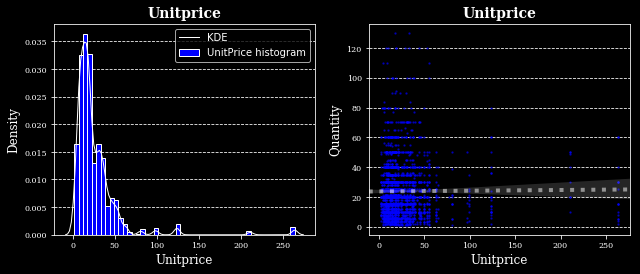

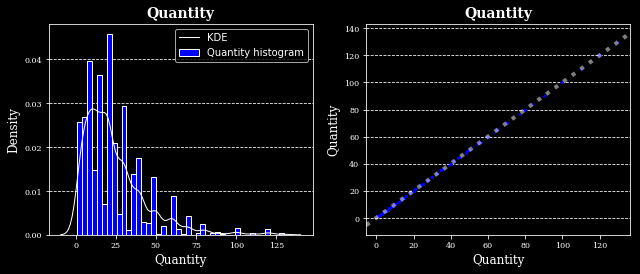

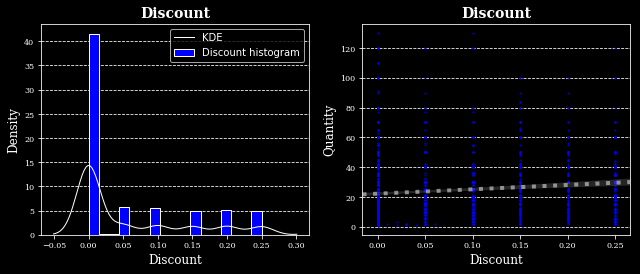

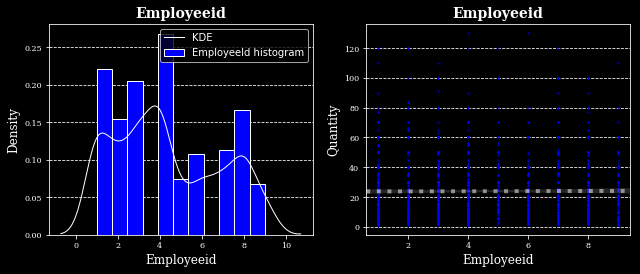

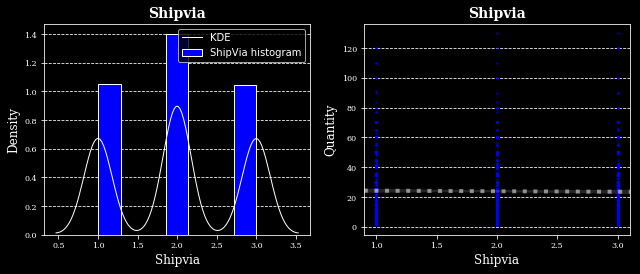

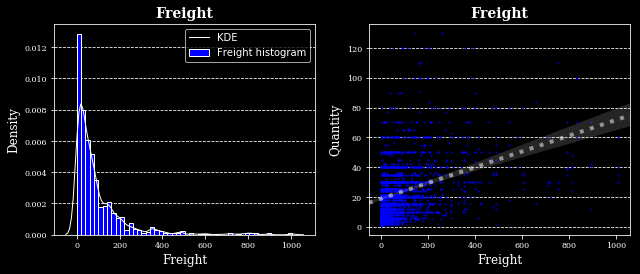

In [41]:
# df['Quantity'].groupby(df['Discount']).plot(kind='bar')
plot_hist_scat_sns(df.drop(['OrderId','ProductId'],axis=1),'Quantity')

#### Note on OrderDetails df:
1. There are 11 possible values for discounts: 
    - Values = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.1, 0.15, 0.2, 0.25]<br>
    - However, there are very few entries for some of the levels of value.<br>
    ``` print(sorted(df['Discount'].unique())) ```
2. The data for quantity looks skewed and not-normal. 
    - Normality tests will likely come back significant 
    

### Aim 1.3: Generated and inspect the required groups
- Generate the groups that we want to test.
    - Discounted
    - Full price 
- Once review, use info to determine next steps.

In [42]:
# Print the descriptive statistics.
df_discounted = df.loc[df['Discount']>0]
df_fullprice = df.loc[df['Discount']==0]

print(f'\nAll Quantities:')
# df.drop(['OrderId','ProductId'],axis=1).describe().round()


All Quantities:


In [43]:
print(f'\nDiscounted Quantities:')

# df_discounted.drop(['OrderId','ProductId'],axis=1).describe().round()


Discounted Quantities:


In [44]:
print(f'Full price Quantities:\n')
df_fullprice.drop(['OrderId','ProductId'],axis=1).describe().round()

Full price Quantities:



,UnitPrice,Quantity,Discount,EmployeeId,ShipVia,Freight
count,1317.0,1317.0,1317.0,1317.0,1317.0,1317.0
mean,26.0,22.0,0.0,4.0,2.0,94.0
std,30.0,18.0,0.0,2.0,1.0,137.0
min,2.0,1.0,0.0,1.0,1.0,0.0
25%,12.0,10.0,0.0,2.0,1.0,15.0
50%,18.0,18.0,0.0,4.0,2.0,47.0
75%,33.0,30.0,0.0,6.0,3.0,117.0
max,264.0,130.0,0.0,9.0,3.0,1008.0


### Plotting Summary EDA Figure

Mean of Full Price: 21.715261958997722
 Mean of Discounted: 27.10978520286396


<Figure size 432x288 with 0 Axes>

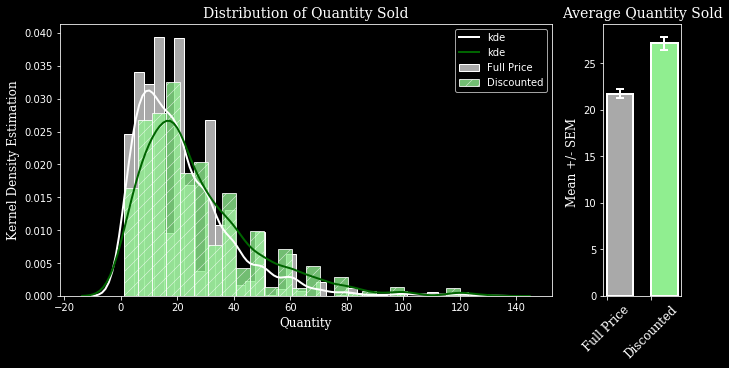

In [45]:
kwargs = {'title_var':'Quantity Sold'}
figa,ax = plot_wide_kde_thin_bar(df_fullprice['Quantity'],'Full Price',df_discounted['Quantity'],'Discounted',**kwargs)

In [46]:
## Uncomment this cell to save the outputs.
# figa.savefig('H1_Kde_bar_Quantity_black.png',dpi=300,facecolor='black')
# df_discounted.to_csv('df_discounted.csv')
# df_fullprice.to_csv('df_fullprice.csv')

In [47]:
# df_fullprice.info(), df_discounted.info()

## ***H1, Aim 2: Select the appropriate t-test based on tests for the assumptions of normality and homogeneity of variance.***
1. **Test for Normality**
    - D'Agostino-Pearson's normality test<br>
    ```scipy.stats.normaltest```
    - Shapiro-Wilik Test<br>
    ```scipy.stats.shapiro```
2. **Test for Homogeneity of Variance**
    - Levene's Test<br>
     ```scipy.stats.levene```

3. **Choose appropriate test based upon 1. and 2.** 
___

### Aim 2.1. Test for Normality

#### Prelminary Testing for Normality 

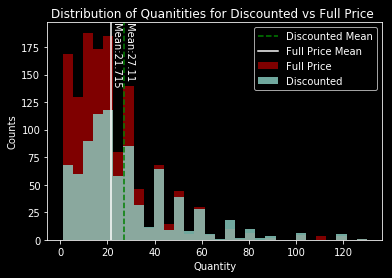

In [48]:
# Plot the re-sampled data

# # IF want to take smaller sample from population:

# pop_samp_disc = np.random.choice(pop_samp_disc,1000)
# pop_samp_full = np.random.choice(pop_samp_full, 1000)
with plt.style.context(('dark_background')):
    
    fig = plt.figure()
    plt.title('Distribution of Quanitities for Discounted vs Full Price ')

    disc = df_discounted['Quantity']
    full = df_fullprice['Quantity']
    
    
    plt.hist(full,color='red', alpha = 0.5, bins=30,label='Full Price')
    plt.hist(disc, alpha = 0.8, bins=30,label='Discounted')

    # Adding annotations
    meanD = round(np.mean(disc),3)
    meanF = round(np.mean(full),3)
    
    plt.axvline(meanD, color='green',linestyle='--',label='Discounted Mean')
    plt.text(meanD,190,f'Mean:{meanD}',rotation=270,fontweight='medium')
    
    plt.axvline(meanF,color='white',linestyle='-',label='Full Price Mean')
    plt.text(meanF, 190, f'Mean:{meanF}',rotation=270,fontweight='medium')

    plt.xlabel('Quantity')
    plt.ylabel('Counts')
    plt.legend()
    plt.show()

# Run normality testing
# stat,p = normaltest(pop_samp_full)
# print(f'Normality: stat ={stat}, p = {p}')

# Run ttest
# tstat,tp = stats.ttest_ind(pop_samp_disc, pop_samp_full)
# print(f'T-test: stat ={tstat}, p = {tp}')#tstat,tp
# ax.text(

In [49]:
# D'Agonstino Pearson Normality Test
from scipy.stats import normaltest 
# Create results container list
results_normtest = [['DataIn','stat','p']]

# Perform Normality Test - Discounted
stat, p = normaltest(df_discounted['Quantity'])
results_normtest.append(['Discounted',stat,p])
print(f'Discounted: p ={p}, stat ={stat}')

# Perform Normality Test - Full Price
stat, p = normaltest(df_fullprice['Quantity'])
results_normtest.append(['Fullprice',stat,p])

print(f'Fullprice: p ={p}, stat ={stat}')
list2df(results_normtest)

Discounted: p =1.6214878452829618e-57, stat =261.528012299789
Fullprice: p =5.579637380545965e-119, stat =544.5770045551502


,DataIn,stat,p
0,Discounted,261.528,1.621e-57
1,Fullprice,544.577,5.580e-119


**Notes on Preliminary Normality Test:**
- Both groups failed assumption of normality. 

    - Let's compare normaltest vs shapiro test
    
- Let's try removing outliers with previously define detect_outliers

#### def normtest_results

In [50]:
def normtest_results(dict_data):
    """Peforms both d'agostino-pearson and shapiro-wilik normal tests
        
        Parameters:
            dict_data -- dictionary with {'name' : data} 
        Returns:
            results_normtest -- list of test results (can run list2df(results_normtest)
    """
    from numpy.random import seed
    from numpy.random import randn
    from scipy.stats import shapiro
    from scipy.stats import normaltest

    results_normtest_shap = [['DataIn','Test','stat','p']]
    results_normtest_dagp = [['DataIn','Test','stat','p']]

    for key,val in dict_data.items():

        data_in = val
        name = key
        test = 'Shapiro'
        stat, p = shapiro(data_in)
        results_normtest_shap.append([name , test, stat , p ])
        test = 'D’Agostino’s'
        stat, p = normaltest(data_in)
        results_normtest_dagp.append([name,test,stat, p])

    results_normtest = pd.concat([list2df(results_normtest_shap), list2df(results_normtest_dagp)]) 

    return results_normtest #, list2df(results_normtest_shap),list2df(results_normtest_dagp)

#   results_pivot = results.pivot(index='DataIn', columns= 'Test')
#   results_pivot.stack(0)

### Sub-Aim 2.1.1 Use detect_outliers to remove outliers re-run normality tests

##### Run detect_outliers on df_discounted, df_fullprice, examine stats of outliers, and then test normality with cleaned data.

In [51]:
# Detect outliers in df_discounted
outlier_disc = detect_outliers(df_discounted,0,['Quantity'])

print(f'\nDescriptive Stats for Discounted Outliers:')
print(f'There are {len(outlier_disc)} outliers out of {len(df)} = {len(outlier_disc)/len(df)*100} %')
df[['Quantity','Discount']].iloc[outlier_disc].describe().round()


Descriptive Stats for Discounted Outliers:
There are 29 outliers out of 2155 = 1.345707656612529 %


,Quantity,Discount
count,29.0,29.0
mean,94.0,0.0
std,17.0,0.0
min,77.0,0.0
25%,80.0,0.0
50%,90.0,0.0
75%,100.0,0.0
max,130.0,0.0


In [52]:
# Detect outliers in df_fullprice
outlier_no_disc = detect_outliers(df_fullprice,0,['Quantity'])
print(f'\nDescriptive Stats for Fullprice Outliers:')
print(f'There are {len(outlier_no_disc)} outliers out of {len(df)} = {len(outlier_no_disc)/len(df)*100}%')
df[['Quantity','Discount']].iloc[outlier_no_disc].describe().round()


Descriptive Stats for Fullprice Outliers:
There are 34 outliers out of 2155 = 1.5777262180974478%


,Quantity,Discount
count,34.0,34.0
mean,86.0,0.0
std,20.0,0.0
min,63.0,0.0
25%,70.0,0.0
50%,80.0,0.0
75%,100.0,0.0
max,130.0,0.0


#### Remove outliers and re-run normality testing

In [53]:
# Indices were from original dataframe still, so dorp outliers from a copy of that 
df_to_clean = df.copy()

# Fill Data to Remove with np.nan
remove_label = ['outlier_disc' , 'outlier_no_disc']
remove_data = [outlier_disc , outlier_no_disc]

remove_me = dict(zip(remove_label, remove_data))

# Loop and replace indices of outliers with np.nan 
for key,val in remove_me.items():
    
    df_to_clean.iloc[val]=np.nan
    
    print(f'{key} removed {len(val)} outliers')

print('After removal:')
print(df_to_clean.isna().sum())

outlier_disc removed 29 outliers
outlier_no_disc removed 34 outliers
After removal:
Id                 63
OrderId            63
ProductId          63
UnitPrice          63
Quantity           63
Discount           63
CustomerId         63
EmployeeId         63
OrderDate          63
RequiredDate       63
ShippedDate       134
ShipVia            63
Freight            63
ShipName           63
ShipAddress        63
ShipCity           63
ShipRegion         63
ShipPostalCode    114
ShipCountry        63
dtype: int64


In [54]:
# Replace na and run stattest 
# df_to_clean.info()

In [55]:
# pause
df_clean = df_to_clean.dropna(axis=0)#,inplace=True)
# df_clean.info(),print(f'\n\nOutliers present:'),df_clean.isna().any()

#### Separate Back into Discounted and Fullprice Dataframes  

In [56]:
# Separate Back into Discounted and Fullprice Dataframes  

# Building data_in dictionary for normtest_results
df_disc_orig = df_discounted
df_full_orig = df_fullprice

df_discounted_clean = df_clean.loc[df_clean['Discount']>0].copy()
# df_discounted_clean.info()
df_fullprice_clean = df_clean.loc[df_clean['Discount']==0].copy()
# df_fullprice_clean.info()

In [57]:
# Combine all data into 1 dictionary for normtest_results.
data_in = {}

data_in['Disc, Orig'] = df_disc_orig['Quantity']
data_in['Disc, Clean'] = df_discounted_clean['Quantity']

data_in['Full Price','Orig'] = df_full_orig['Quantity']
data_in['Full Price','Clean'] = df_fullprice_clean['Quantity']

In [58]:
# Run normtest_results on combined dataset.
results = normtest_results(data_in) #[0]
results.set_index('DataIn')

,Test,stat,p
DataIn,,,
"Disc, Orig",Shapiro,0.869,6.881e-26
"Disc, Clean",Shapiro,0.921,2.661e-19
"(Full Price, Orig)",Shapiro,0.843,3.804e-34
"(Full Price, Clean)",Shapiro,0.917,1.903e-25
"Disc, Orig",D’Agostino’s,261.528,1.621e-57
"Disc, Clean",D’Agostino’s,80.420,3.444e-18
"(Full Price, Orig)",D’Agostino’s,544.577,5.580e-119
"(Full Price, Clean)",D’Agostino’s,140.846,2.605e-31


**Notes re: removing outliers with detect_outliers.**
- Still getting significant results for normality testing. 
- Attempting 1 more method of outlier removal -- QuantileTransformer<br>
```from sklearn.preprocessing import QuantileTransformer```

### Sub-Aim 2.1.2 Use QuantileTransformer to attempt to meet the assumption of normality.

#### def quant_transform 

In [59]:
# TRANSFORM DATA BEFORE RE-CALLING ORIGINAL normtest_results
def quant_transform(data_in):
    '''Use sklearn.preprocessing.QuantileTransformer to remove outliers from dataset.
    
    Parameters:
        data_in (dict) -- dictionary with data series as values to be processed.
    Returns: 
        data_tf (dict) -- dicionary of same keys from data_in, but transformed.
        '''
    
    from sklearn import preprocessing as prep 
    from sklearn.preprocessing import QuantileTransformer

    qt =  QuantileTransformer(n_quantiles=10,output_distribution='normal')
    data_tf = {}
    for k,v in data_in.items():    
        data = np.array(v).reshape(-1,1)
        transformed = pd.Series(np.squeeze(qt.fit_transform(data)))
      
        data_tf[k] = transformed
    
    return data_tf

In [60]:
# Run data_in through quant_transform to get data_tf
data_tf = quant_transform(data_in)

# Run transformed data through normtest_results.
trans_norm_test = normtest_results(data_tf)#[0]
trans_norm_test

,DataIn,Test,stat,p
0,"Disc, Orig",Shapiro,0.956,3.410e-15
1,"Disc, Clean",Shapiro,0.855,1.641e-25
2,"(Full Price, Orig)",Shapiro,0.919,5.725e-26
3,"(Full Price, Clean)",Shapiro,0.860,1.033e-31
0,"Disc, Orig",D’Agostino’s,103.590,3.203e-23
1,"Disc, Clean",D’Agostino’s,110.340,1.096e-24
2,"(Full Price, Orig)",D’Agostino’s,317.580,1.093e-69
3,"(Full Price, Clean)",D’Agostino’s,327.580,7.362e-72


In [61]:
# dataDict = {'Original':data_in,'Transformed':data_in_tf }
# # df_data = normtest_results(data_in)[0]
# dataDict_results = {'Original-Results':normtest_results(data_in),'Transformed-Results': normtest_results(data_in_tf)}

In [62]:
# # Display info for 
# printDict=dataDict
# print(f'dataDict')

# for key, val in printDict.items():
#   print(key)
#   for k, v in printDict[key].items():
#     print(f'   {k}\n         has {len(v)} values with mean={np.mean(v)}')


### Sub-Aim 2.1.3 Use resampling to get a normal distribution from the data and re-run normality tests.

In [63]:
data_discounted = df['Quantity'].loc[df['Discount']>0].copy()
data_fullprice = df['Quantity'].loc[df['Discount']==0].copy()

In [64]:
# Resample our data  i # of samples with n =50/sample 
n = 50 
i = 10000
pop_samp_disc = []
pop_samp_full = []
for i in range(0,i):
    
    pop_samp_disc.append(data_discounted.sample(n).mean())
    pop_samp_full.append(data_fullprice.sample(n).mean())
    #   test_results.append(normaltest())
    # plt.hist([pop_samp_disc,pop_samp_full])

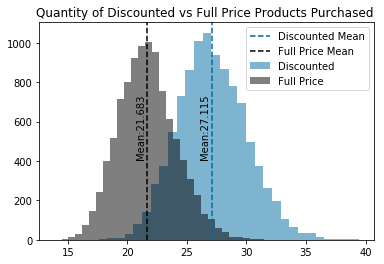

Normality: stat =136.4316508077141, p = 2.3672463120234925e-30


In [65]:
# Plot the re-sampled data

# # IF want to take smaller sample from population:

# pop_samp_disc = np.random.choice(pop_samp_disc,1000)
# pop_samp_full = np.random.choice(pop_samp_full, 1000)
with plt.style.context(('tableau-colorblind10')):
    fig = plt.figure()
    
    plt.title('Quantity of Discounted vs Full Price Products Purchased ')
    
    plt.hist(pop_samp_disc,alpha = 0.5, bins=30,label='Discounted')
    plt.hist(pop_samp_full,color='black', alpha = 0.5, bins=30,label='Full Price')

    # Adding annotations
    meanD = round(np.mean(pop_samp_disc),3)
    meanS = round(np.mean(pop_samp_full),3)
    
    plt.axvline(meanD, linestyle='--',label='Discounted Mean')
    plt.text(meanD-1,700,f'Mean:{meanD}',rotation=90)
    
    plt.axvline(meanS,color='k',linestyle='--',label='Full Price Mean')
    plt.text(meanS-1,700,f'Mean:{meanS}',rotation=90)


    plt.legend()
    plt.show()

# Run normality testing
stat,p = normaltest(pop_samp_full)
print(f'Normality: stat ={stat}, p = {p}')

# Run ttest
tstat,tp = stats.ttest_ind(pop_samp_disc, pop_samp_full)
# print(f'T-test: stat ={tstat}, p = {tp}')#tstat,tp
# ax.text(

#### H1, Aim 2 Preliminary notes.
- Regardless of transformations, we do not pass normality test.
- Switching tactics and letting the the tests for assumptions of normality and equal variance decide the appropriate test


___
## ***H1, Aim 2: Final Workflow for testing assumptions***

#### New Statistical Analysis Pipeline
1. **Test for Normality**
    - D'Agostino-Pearson's normality test<br>
    ```scipy.stats.normaltest```
    - Shapiro-Wilik Test<br>
    ```scipy.stats.shapiro```<br>
    
2. **Test for Homogeneity of Variance**
    - Levene's Test<br>
    ```scipy.stats.levene```

3. **Choose appropriate test based upon 1. and 2.** <br> 
    - Welch's T-Test
    - Mann Whitney U
    - ANOVA 
    - Tukey's
    
4. Calculate effect size for significant results. 
    - Effect size: [cohen's d](https://stackoverflow.com/questions/21532471/how-to-calculate-cohens-d-in-python)
    - Interpretation:
        - Small effect = 0.2 ( cannot be seen by naked eye)
        - Medium effect  = 0.5
        - Large Effect = 0.8 (can be seen by naked eye)
        
5. If significant, follow up with post-hoc tests (if have more than 2 groups)
    - [Tukey's](https://www.statsmodels.org/stable/generated/statsmodels.stats.multicomp.pairwise_tukeyhsd.html)


In [66]:
# 1 - Separating groups from dfH (dataframeHypothesis)
dfH = df[['Quantity','UnitPrice','Discount']].copy()

#Adding group definitions
grpA = "['Discount'] > 0"
grpB = "['Discount'] == 0"

# Using eval to create df_A and df_B; will allow us to fill in our results 
# with the exact definitions of Group A and Group B
df_A = eval(f'dfH.loc[dfH{grpA}]')
df_B = eval(f'dfH.loc[dfH{grpB}]')

# dfj_D = dfH.loc[dfj['Discount']>0] 
# dfj_F = dfH.loc[dfj['Discount']==0]
df_A.describe(),'--'*25,df_B.describe()

(       Quantity  UnitPrice  Discount
 count   838.000   838.000    838.000
 mean     27.110    26.292      0.144
 std      20.771    30.017      0.072
 min       1.000     2.000      0.010
 25%      12.000    12.500      0.100
 50%      20.000    18.000      0.150
 75%      36.000    31.230      0.200
 max     130.000   263.500      0.250,
 '--------------------------------------------------',
        Quantity  UnitPrice  Discount
 count  1317.000  1317.000    1317.0 
 mean     21.715    26.172       0.0 
 std      17.507    29.717       0.0 
 min       1.000     2.000       0.0 
 25%      10.000    12.000       0.0 
 50%      18.000    18.400       0.0 
 75%      30.000    32.800       0.0 
 max     130.000   263.500       0.0 )

### Aim 2.1: Test for Normality

In [67]:
# Adding table to collect summary statistics
H1_tests = [['Group:','TestName','Test Purpose','stat','p','p<.05?']  ]

In [68]:
# H1_tests = [['Group:','TestName','Test Purpose','stat','p']  ]
# 2. Testing normality

test_purpose = 'Normality'
test_to_run = 'normaltest'

arrA = np.array(df_A['Quantity'])
arrB = np.array(df_B['Quantity'])

statA, pA = eval(test_to_run)(arrA)
statB, pB = eval(test_to_run)(arrB)

print(f'A:stat={statA}, p={pA}')
print(f'B:stat={statB}, p={pB}')

# H1_tests = [['Group:','TestName','Test Purpose','stat','p']  ]
H1_tests.append(['A: '+grpA,test_to_run,test_purpose,statA,pA, pA<.05])
H1_tests.append(['B: '+grpB,test_to_run,test_purpose,statB,pB, pB<.05])
# list2df(H1_tests)

A:stat=261.528012299789, p=1.6214878452829618e-57
B:stat=544.5770045551502, p=5.579637380545965e-119


In [69]:
list2df(H1_tests).round(4)

,Group:,TestName,Test Purpose,stat,p,p<.05?
0,A: ['Discount'] > 0,normaltest,Normality,261.528,0.0,True
1,B: ['Discount'] == 0,normaltest,Normality,544.577,0.0,True


### Aim 2.2 Test for Homogeneity of Variance

In [70]:
# 3. Test for homo var
test_to_run = 'stats.levene'
stat,p = eval(test_to_run)(arrA,arrB,center='median')

H1_tests.append(['A&B',test_to_run,'Equal Var',stat,p, p<.05])

### Aim 2.3 Selecting the appropriate test to perform.

In [71]:
list2df(H1_tests)

,Group:,TestName,Test Purpose,stat,p,p<.05?
0,A: ['Discount'] > 0,normaltest,Normality,261.528,1.621e-57,True
1,B: ['Discount'] == 0,normaltest,Normality,544.577,5.580e-119,True
2,A&B,stats.levene,Equal Var,14.833,1.209e-04,True


### Conclusions so far...
- We failed both normaltests and homo variance
- Need non-parametric 2sample ttest
    - [**Mann-Whitney U test**](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html)

In [72]:
#### Mann-Whitney U test

In [73]:
# Mann Whitney U test+
import scipy.stats as stats
# arrA was discounted, arrB was non-discounted
test_to_run = 'stats.mannwhitneyu'
stat, p = eval(test_to_run)(arrA,arrB,alternative='greater')
stat, p
H1_tests.append(['A vs. B',test_to_run, 'H1_sig', stat,p, p<.05])

In [74]:
list2df(H1_tests)

,Group:,TestName,Test Purpose,stat,p,p<.05?
0,A: ['Discount'] > 0,normaltest,Normality,261.528,1.621e-57,True
1,B: ['Discount'] == 0,normaltest,Normality,544.577,5.580e-119,True
2,A&B,stats.levene,Equal Var,14.833,1.209e-04,True
3,A vs. B,stats.mannwhitneyu,H1_sig,642105.000,6.629e-11,True


#### Calculating Effect Size

In [75]:
ls

 Volume in drive D is Storage HD
 Volume Serial Number is 11EC-B280

 Directory of D:\Users\James\Dropbox (Personal)\CODING\_FLATIRON\Mod2_FinalProject\dsc-2-final-project-online-ds-ft-021119

04/09/2019  08:37 PM    <DIR>          .
04/09/2019  08:37 PM    <DIR>          ..
03/29/2019  04:47 PM                66 .gitignore
04/09/2019  07:41 PM    <DIR>          .ipynb_checkpoints
03/29/2019  04:47 PM                95 .learn
03/29/2019  04:47 PM           526,610 adventureworks2008_schema.gif
04/04/2019  02:01 PM            19,365 Blog Post.docx
03/29/2019  04:47 PM             1,849 CONTRIBUTING.md
04/09/2019  12:55 PM               763 CSS.css
04/08/2019  10:57 PM             1,395 dark_james.mplstyle
04/08/2019  08:38 PM           133,670 df_H3_price_w_dates_orders.csv
04/08/2019  08:38 PM           346,718 df_H3_price_w_dates_products.csv
04/09/2019  03:54 PM    <DIR>          Exported CSV
04/09/2019  04:41 PM    <DIR>          Figures
04/08/2019  08:38 PM           100,327 H1_Avg

In [76]:
# Calculating Cohens d
d = Cohen_d(arrA,arrB)
print(f"Cohen's d={round(d,3)}")

# Append H1_tests and export result. 
H1_tests.append(['A vs. B',"Cohen's d",'Effect Size',d,'--','--'])
table_H1_test_results = list2df(H1_tests)

# Export csv if user sets save_for_user to True
if save_for_user==True:
    table_H1_test_results.to_csv(data_filepath+'table_H1_test_results.csv')
    table_H1_test_results.round(4).to_html(data_filepath+'table_H1_test_results.html')


# Display output                          
table_H1_test_results

Cohen's d=0.286


,Group:,TestName,Test Purpose,stat,p,p<.05?
0,A: ['Discount'] > 0,normaltest,Normality,261.528,1.62e-57,True
1,B: ['Discount'] == 0,normaltest,Normality,544.577,5.58e-119,True
2,A&B,stats.levene,Equal Var,14.833,0.000121,True
3,A vs. B,stats.mannwhitneyu,H1_sig,642105.000,6.63e-11,True
4,A vs. B,Cohen's d,Effect Size,0.286,--,--


In [77]:
# Save table of basic info on central tendency
from scipy.stats import sem
H1_mean_sem = [['H#','Group','mean','sem','std','n']]

dataArr=arrA
H1_mean_sem.append(['H1',f'A:{grpA}',np.mean(dataArr),sem(dataArr), np.std(dataArr),len(dataArr)])

dataArr=arrB
H1_mean_sem.append(['H1',f'B:{grpB}',np.mean(dataArr),sem(dataArr), np.std(dataArr),len(dataArr)])

table_H1_mean_sem = list2df(H1_mean_sem)

# Export csv if user sets save_for_user to True
if save_for_user==True:
    table_H1_mean_sem.to_csv(data_filepath+'table_H1_mean_sem.csv')    
    table_H1_mean_sem.round(2).to_html(data_filepath+'table_H1_mean_sem.html')    

table_H1_mean_sem

,H#,Group,mean,sem,std,n
0,H1,A:['Discount'] > 0,27.110,0.718,20.759,838
1,H1,B:['Discount'] == 0,21.715,0.482,17.501,1317


#### Interpretation of results. 
**We have a significant Mann Whitney U results, but we have yet to say anything about**
- We should now run post-hoc tests using pairwise Tukey's tests 
- Compare all levels of discount in pairwise comparisons 

## ***H1, Aim 3: To perform post-hoc pairwise comparisons for level of discount***
- **To find out which level of discount is most effective/significant.**

In [78]:
pd.DataFrame(df['Discount'].value_counts().sort_index())

,Discount
0.00,1317
0.01,1
0.02,2
0.03,3
0.04,1
0.05,185
0.06,1
0.10,173
0.15,157
0.20,161


In [79]:
# df.info()

### Creating Discount Level Variables for Tukey
- Adding LabelEncoding
- Question: do we want to have "None" encoded? Not sure. Would need to replace the current np.NaN with "NaN" first or likely will return error

In [80]:
# intervalIndex = pd.IntervalIndex(())
df_cut = df.copy().drop('Discount',axis=1)

new_discounts = pd.cut(df['Discount'],[-0.05,0.0,0.05,0.10,0.15,0.20,0.25,0.3], include_lowest=False)
new_discouts = new_discounts.cat.as_ordered(inplace=True)
df_disc_codes  = new_discounts.cat.codes

# Save code info for later
disc_intervals = new_discounts.unique().sort_values()
disc_codes = sorted(df_disc_codes.unique())

# Save the intervals 
labelCodes = tuple(zip(disc_intervals,disc_codes))
labelCodes

((Interval(-0.05, 0.0, closed='right'), 0),
 (Interval(0.0, 0.05, closed='right'), 1),
 (Interval(0.05, 0.1, closed='right'), 2),
 (Interval(0.1, 0.15, closed='right'), 3),
 (Interval(0.15, 0.2, closed='right'), 4),
 (Interval(0.2, 0.25, closed='right'), 5))

In [81]:
# Before encoding
df_H1codes = pd.concat([df_cut,new_discounts,df_disc_codes],axis=1)
# df_H1codes.info()
# df_H1codes.Discount.unique()

In [82]:
# colnames = list(df_H1codes.columns)
# colnames[-1] = 'DiscSize'
# df_H1codes.columns = colnames
# df_H1codes.head()

### Use Tukey's Pairwise Multiple Comparison test.
```statsmodels.stats.multicomp.pairwise_tukeyhsd```

In [83]:
# Importing tukey's test
from statsmodels.stats.multicomp import pairwise_tukeyhsd as tukey
int_str = [str(x) for x in new_discounts]

# Run tukey's test
tukey_results =tukey(df_H1codes['Quantity'], int_str, 0.05)

table_H1_tukey = tukey_table(tukey_results)

if save_for_user==True:
    table_H1_tukey.to_csv(data_filepath+'table_H1_tukey.csv')
    table_H1_tukey.round(4).to_html(data_filepath+'table_H1_tukey.html')
tukey_results.summary()


group1,group2,meandiff,lower,upper,reject
"(-0.05, 0.0]","(0.0, 0.05]",5.3368,1.1841,9.4895,True
"(-0.05, 0.0]","(0.05, 0.1]",3.3882,-0.9479,7.7243,False
"(-0.05, 0.0]","(0.1, 0.15]",6.6669,2.1282,11.2056,True
"(-0.05, 0.0]","(0.15, 0.2]",5.3096,0.8215,9.7977,True
"(-0.05, 0.0]","(0.2, 0.25]",6.525,1.9469,11.1031,True
"(0.0, 0.05]","(0.05, 0.1]",-1.9486,-7.5752,3.6779,False
"(0.0, 0.05]","(0.1, 0.15]",1.3301,-4.4541,7.1143,False
"(0.0, 0.05]","(0.15, 0.2]",-0.0272,-5.7718,5.7173,False
"(0.0, 0.05]","(0.2, 0.25]",1.1882,-4.6269,7.0033,False
"(0.05, 0.1]","(0.1, 0.15]",3.2787,-2.6385,9.196,False


In [84]:
table_H1_tukey.loc[table_H1_tukey['reject']==True]

,group1,group2,meandiff,lower,upper,reject
0,"(-0.05, 0.0]","(0.0, 0.05]",5.337,1.184,9.489,True
2,"(-0.05, 0.0]","(0.1, 0.15]",6.667,2.128,11.206,True
3,"(-0.05, 0.0]","(0.15, 0.2]",5.310,0.822,9.798,True
4,"(-0.05, 0.0]","(0.2, 0.25]",6.525,1.947,11.103,True


### Plotting summary post-hoc figure

In [85]:
from scipy.stats import sem
# fig = plt.figure()
# ax = fig.add_subplot(111)

H1_means = df_H1codes.groupby('Discount')['Quantity'].mean()
H1_sem = df_H1codes.groupby('Discount')['Quantity'].sem()
H1_std = df_H1codes.groupby('Discount')['Quantity'].std()
H1_index = H1_means.index

In [86]:
# H1_index

In [87]:
# H1_means.index
xticklabels = ['0 %','<=5 %','5-10 %','10-15 %','15-20 %','20-25 %','25-30 %']
plot_data = {'index':H1_index,'labels':xticklabels,'mean':H1_means,'sem':H1_sem,'std':H1_std}
df_plot = pd.DataFrame.from_dict(plot_data,orient='columns')
df_plot.info(), df_plot.set_index('labels',inplace=True)

df_plot

<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 7 entries, (-0.05, 0.0] to (0.25, 0.3]
Data columns (total 5 columns):
index     7 non-null category
labels    7 non-null object
mean      6 non-null float64
sem       6 non-null float64
std       6 non-null float64
dtypes: category(1), float64(3), object(1)
memory usage: 462.0+ bytes


,index,mean,sem,std
labels,,,,
0 %,"(-0.05, 0.0]",21.715,0.482,17.507
<=5 %,"(0.0, 0.05]",27.052,1.612,22.331
5-10 %,"(0.05, 0.1]",25.103,1.607,21.199
10-15 %,"(0.1, 0.15]",28.382,1.670,20.923
15-20 %,"(0.15, 0.2]",27.025,1.484,18.833
20-25 %,"(0.2, 0.25]",28.240,1.621,20.121
25-30 %,"(0.25, 0.3]",NaN,NaN,NaN


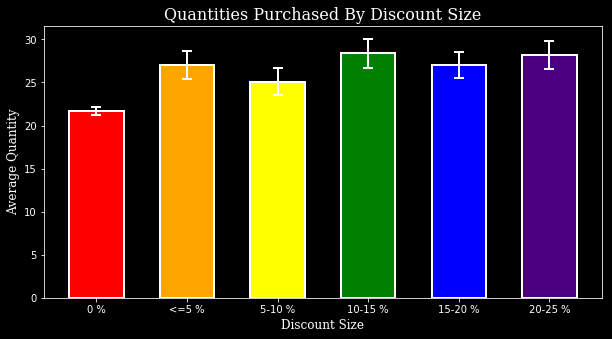

In [88]:
with plt.style.context('dark_background'):
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(1,1,1)
    
    color = ['red','orange','yellow','green','blue','indigo','violet']
    
    err_kws = {'ecolor': 'w', 'capsize':5,
               'elinewidth': 2 ,'capthick': 2}
    
    fontTitle = {'fontfamily':'serif',
               'fontweight':'medium',
               'fontsize':16}
    
    fontAxis = {'fontfamily':'serif',
               'fontweight':'medium',
               'fontsize':12}
    
    ax.bar(x = df_plot.index,width=0.6, height = df_plot['mean'], yerr = df_plot['sem'], error_kw=err_kws,
          edgecolor='white', linewidth = 2,color = color)
    
    ax.set_title('Quantities Purchased By Discount Size',fontdict=fontTitle)
    ax.set_ylabel('Average Quantity',fontdict=fontAxis)
    ax.set_xlabel('Discount Size', fontdict=fontAxis)
    
#     plt.tight_layout()
    plt.show()

In [89]:
# Save figure of save_for_user is True
if save_for_user == True:
    # ## Uncomment this cell in order to save the image.*
    fig.savefig(fig_filepath+'H1_Avg_quantity_by_discount.png', dpi=300, frameon=True,facecolor='k')

## ***Conclusions for Hypothesis 1:***


In [90]:
display(table_H1_test_results)

,Group:,TestName,Test Purpose,stat,p,p<.05?
0,A: ['Discount'] > 0,normaltest,Normality,261.528,1.62e-57,True
1,B: ['Discount'] == 0,normaltest,Normality,544.577,5.58e-119,True
2,A&B,stats.levene,Equal Var,14.833,0.000121,True
3,A vs. B,stats.mannwhitneyu,H1_sig,642105.000,6.63e-11,True
4,A vs. B,Cohen's d,Effect Size,0.286,--,--


1. **We first used D'Agostino & Perason's test (normaltest) to check for normal distributions**
    -  Both groups had p-values very far below our $\alpha=0.05$  (Rows 0,1 below)
        - We rejecteded the null hypothesis that the groups came from a populatiin with a normal distribtuion. 
2. **We tested for equal variances using Levene's test.**
    - Level's test had a signifcant p-value, so we rejected the hypothesis that the groups have equal variances
    
3. **We then concluded we need a non-parametric 2-sample test, so we used the Mann-Whitney U test**. 
    -  Our comparison had a p-value less than .05
    - We reject the null hypothesis that discounts do not affect quantities sold.



4. **To determine which level of discounts had the largest effect, we performed a pairwise multiple comparison Tukey's test**. 
    - Our results showed that discounts of 0-5%, 10-15%, 15-20%, and 20-25% were all significantly different from full price products. 
        - Except 5-10 % discount group
    - No discount groups were significantly different than other discount groups.
    

In [91]:
# Save the results into a dataframe
table_H1_tukey.loc[table_H1_tukey['reject']==True]

,group1,group2,meandiff,lower,upper,reject
0,"(-0.05, 0.0]","(0.0, 0.05]",5.337,1.184,9.489,True
2,"(-0.05, 0.0]","(0.1, 0.15]",6.667,2.128,11.206,True
3,"(-0.05, 0.0]","(0.15, 0.2]",5.310,0.822,9.798,True
4,"(-0.05, 0.0]","(0.2, 0.25]",6.525,1.947,11.103,True


In [92]:
# df_H1codes.info(),
# dfH.index

In [93]:
# # Save results to new dataframe
# df_orig_save = df_H1codes.copy()
# dfH1_save = dfH.copy()

___
# **Hypothesis 2:**


> **Do customers spend more money if they are buying discounted items?**

- $H_1$: Customers spend more money overall when their order includes discounted items.

- $H_0$: Customers spend the same amount regardless of discounted items. 

**Specific Aims:**

* ***Aim 1:To select the proper dataset for analysis, perform EDA, and generate data groups for testing.***
    - Used sqlalchemy and pandas.read_sql_query()
    
    ```python 
query = "SELECT* FROM OrderDetails,
            GROUPBY discount```

* ***Aim 2: Select the appropriate t-test based on tests for the assumptions of normality and homogeneity of variance.***
    1. **Test for Normality**
        - D'Agostino-Pearson's normality test<br>
        ```scipy.stats.normaltest```
        - Shapiro-Wilik Test<br>
        ```scipy.stats.shapiro```
    2. **Test for Homogeneity of Variance**
        - Levene's Test<br>
         ```scipy.stats.levene```

    3. **Choose appropriate test based upon 1. and 2.** <br> 
    
    
* ***Aim 3: To perform post-hoc painrwise comparison testing to determine which level of discounts affect quantity and if any discount has a greater effect than the others.***

     - Tukey's test for multiple pairwise comparisons

_________
## ***H2, Aim 1 : To select the proper dataset for analysis  and generate data groups for testing.***

#### Importing Method
- Used sqlalchemy to create engine to connect to Northwind_small.sqlite.
- used ```pd.read_sql_query('SELECT * FROM OrderDetail',engine)``` to directly read db into df

In [94]:
# filepath = '/content/drive/My Drive/Colab Notebooks/datasets/Northwind_small.sqlite'
# filepath = 'Northwind_small.sqlite'
#-------------------
# Testing minimal version of prior code
import sqlite3
from sqlalchemy import create_engine, inspect
# from sqlalchemy import Table, Column, Integer, String, MetaData, ForeignKey,text, Float

engine = create_engine('sqlite:///'+filepath,echo=True);
inspector = inspect(engine);
db_tables = inspector.get_table_names();
print('\n',db_tables);

2019-04-09 20:38:23,918 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-04-09 20:38:23,919 INFO sqlalchemy.engine.base.Engine ()
2019-04-09 20:38:23,921 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-04-09 20:38:23,921 INFO sqlalchemy.engine.base.Engine ()
2019-04-09 20:38:23,923 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2019-04-09 20:38:23,924 INFO sqlalchemy.engine.base.Engine ()

 ['Category', 'Customer', 'CustomerCustomerDemo', 'CustomerDemographic', 'Employee', 'EmployeeTerritory', 'Order', 'OrderDetail', 'Product', 'Region', 'Shipper', 'Supplier', 'Territory']


In [95]:
# We want to test hypothesis one, so we need OrderDetail table.
table_to_test = "OrderDetail"
df = pd.read_sql_query("SELECT * FROM OrderDetail",  engine)
df.head()

2019-04-09 20:38:23,933 INFO sqlalchemy.engine.base.Engine SELECT * FROM OrderDetail
2019-04-09 20:38:23,933 INFO sqlalchemy.engine.base.Engine ()


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


### Aim 1.1: Calculating order totals, adding discount groups

In [96]:

# Apply calc_product_price to every row 
df_price = df.apply(lambda x: calc_product_price(x),axis=1)
# df_price['order_total'] = None

# Apply_calc_order_total to every row
df_price = df_price.apply(lambda x: calc_order_total(x,df_price), axis=1)  
df_price.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,price,OnSale,discounted_order,order_total
0,10248/11,10248,11,14.0,12,0.0,168.0,0,0,440.0
1,10248/42,10248,42,9.8,10,0.0,98.0,0,0,440.0
2,10248/72,10248,72,34.8,5,0.0,174.0,0,0,440.0
3,10249/14,10249,14,18.6,9,0.0,167.4,0,0,1863.4
4,10249/51,10249,51,42.4,40,0.0,1696.0,0,0,1863.4


### Aim 1.2: EDA on dataset 


Mean of Full Price: 1748.1294774774774
 Mean of Discounted: 1967.286576076555


<Figure size 432x288 with 0 Axes>

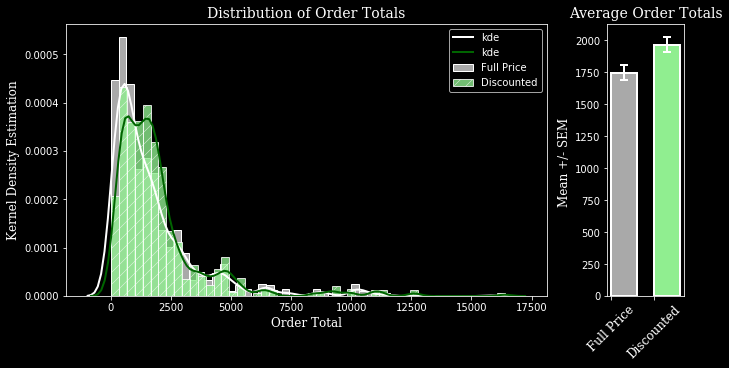

In [97]:
import warnings
warnings.filterwarnings("ignore")
# Define groups
# A: discounted df_price.groupby('discounted_order').get_group(1)
# B: full price df_price.groupbt('discounted_order').get_group(0)
grpA = df_price.groupby('discounted_order').get_group(1)
grpB = df_price.groupby('discounted_order').get_group(0)

kwargs = {'title_var':'Order Totals'}
fig, ax =plot_wide_kde_thin_bar(grpB['order_total'],'Full Price',grpA['order_total'],'Discounted',**kwargs)


In [98]:
# Save figure of save_for_user is True
if save_for_user == True:
    fig.savefig(fig_filepath+'H2_kde_bar_black.png',dpi=300,facecolor='k')

In [99]:
# 1 - Separating groups from dfH (dataframeHypothesis)
df_temp = df_price[['OrderId','order_total','discounted_order']]

unique_orders = df_temp['OrderId'].unique()

len(unique_orders)
keep_me=[['OrderId','order_total','discounted_order']]

for u in unique_orders:
#     grouped = dfH.groupby('OrderId').get_group(u)
#     keep_me.append(grouped.iloc[0,:])
    grouped_idx = df_temp.groupby('OrderId').get_group(u).index
    keep_me.append(df_temp.loc[grouped_idx[0]])
dfH = list2df(keep_me)
dfH.head()

,OrderId,order_total,discounted_order
0,10248.0,440.00,0.0
3,10249.0,1863.40,0.0
5,10250.0,1552.60,1.0
8,10251.0,654.06,1.0
11,10252.0,3597.90,1.0


In [100]:
dfH[['order_total','discounted_order']].groupby('discounted_order').describe()#.stack()

order_total                                              \
                    count       mean      std     min    25%      50%      
discounted_order                                                           
0.0                  450.0    1375.332  1792.781  12.5  360.25   810.250   
1.0                  380.0    1702.352  1892.448  23.8  587.75  1244.885   

                                    
                   75%      max     
discounted_order                    
0.0               1731.67  15810.0  
1.0               2027.91  16387.5

In [101]:
#Adding group definitions
grpA = "['discounted_order'] == True"
grpB = "['discounted_order'] == False"

# Using eval to create df_A and df_B; will allow us to fill in our results 
# with the exact definitions of Group A and Group B
df_A = eval(f'dfH.loc[dfH{grpA}]')
df_B = eval(f'dfH.loc[dfH{grpB}]')

# dfj_D = dfH.loc[dfj['Discount']>0] 
# dfj_F = dfH.loc[dfj['Discount']==0]
df_A.describe(),'--'*25,df_B.describe()

(        OrderId   order_total  discounted_order
 count    380.000     380.000         380.0     
 mean   10659.555    1702.352           1.0     
 std      234.869    1892.448           0.0     
 min    10250.000      23.800           1.0     
 25%    10460.750     587.750           1.0     
 50%    10649.000    1244.885           1.0     
 75%    10854.250    2027.910           1.0     
 max    11077.000   16387.500           1.0     ,
 '--------------------------------------------------',
         OrderId   order_total  discounted_order
 count    450.000     450.000         450.0     
 mean   10664.987    1375.332           0.0     
 std      244.019    1792.781           0.0     
 min    10248.000      12.500           0.0     
 25%    10447.250     360.250           0.0     
 50%    10678.500     810.250           0.0     
 75%    10884.500    1731.670           0.0     
 max    11073.000   15810.000           0.0     )

## ***H2, Aim 2: Select the appropriate t-test based on tests for the assumptions of normality and homogeneity of variance.***

In [102]:
# Adding table to collect summary statistics
H2_tests = [['Group:','TestName','Test Purpose','stat','p','p<.05?']  ]

### Aim 2.1: Test for Normality

In [103]:
# 2. Testing normality
test_purpose = 'Normality'
test_to_run = 'normaltest'

arrA = np.array(df_A['order_total'])
arrB = np.array(df_B['order_total'])

statA, pA = eval(test_to_run)(arrA)
statB, pB = eval(test_to_run)(arrB)

print(f'A:stat={statA}, p={pA}')
print(f'B:stat={statB}, p={pB}')

H2_tests.append(['A: '+grpA,test_to_run,test_purpose,statA,pA,pA<.05])
H2_tests.append(['B: '+grpB,test_to_run,test_purpose,statB,pB,pB<.05])
# list2df(H1_tests)

A:stat=309.8566632385119, p=5.193743376505954e-68
B:stat=368.4093987857893, p=1.0021102701214462e-80


In [104]:
list2df(H2_tests)

,Group:,TestName,Test Purpose,stat,p,p<.05?
0,A: ['discounted_order'] == True,normaltest,Normality,309.857,5.194e-68,True
1,B: ['discounted_order'] == False,normaltest,Normality,368.409,1.002e-80,True


### Aim 2.2 Test for Homogeneity of Variance

In [105]:
# 3. Test for homo var
test_to_run = 'stats.levene'
stat,p = eval(test_to_run)(arrA,arrB,center='median')

H2_tests.append(['A&B',test_to_run,'Equal Var',stat,p,p<.05])

In [106]:
list2df(H2_tests)

,Group:,TestName,Test Purpose,stat,p,p<.05?
0,A: ['discounted_order'] == True,normaltest,Normality,309.857,5.194e-68,True
1,B: ['discounted_order'] == False,normaltest,Normality,368.409,1.002e-80,True
2,A&B,stats.levene,Equal Var,0.714,3.983e-01,False


### Aim 2.3 Selecting the appropriate test to perform.
- We failed both normaltests
- We passed Levene's test for homo. of variance
- Need non-parametric 2sample ttest
    - [**Mann-Whitney U test**](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html)

#### Mann-Whitney U test

In [107]:
# Mann Whitney U test+
import scipy.stats as stats
# arrA was discounted, arrB was non-discounted
test_to_run = 'stats.mannwhitneyu'
stat, p = eval(test_to_run)(arrA,arrB,alternative='greater')
stat, p
H2_tests.append(['A vs. B',test_to_run, 'H2_sig', stat,p,p<.05])

In [108]:
list2df(H2_tests)

,Group:,TestName,Test Purpose,stat,p,p<.05?
0,A: ['discounted_order'] == True,normaltest,Normality,309.857,5.194e-68,True
1,B: ['discounted_order'] == False,normaltest,Normality,368.409,1.002e-80,True
2,A&B,stats.levene,Equal Var,0.714,3.983e-01,False
3,A vs. B,stats.mannwhitneyu,H2_sig,102021.000,7.901e-07,True


#### Calculating Effect Size

In [109]:
# Calculating Cohens d
d = Cohen_d(arrA,arrB)
print(f"Cohen's d={round(d,3)}")
H2_tests.append(['A vs. B',"Cohen's d",'Effect Size',d,'--','--'])
table_H2_test_results = list2df(H2_tests)

if save_for_user==True:
    table_H2_test_results.to_csv(data_filepath+'table_H2_test_results.csv')
    table_H2_test_results.round(4).to_html(data_filepath+'table_H2_test_results.html')

Cohen's d=0.178


In [110]:
# Save table of basic info on central tendency
from scipy.stats import sem
H2_mean_sem = [['H#','Group','mean','sem','std','n']]

dataArr=arrA
H2_mean_sem.append(['H2',f'A:{grpA}',np.mean(dataArr),sem(dataArr), np.std(dataArr),len(dataArr)])

dataArr=arrB
H2_mean_sem.append(['H2',f'B:{grpB}',np.mean(dataArr),sem(dataArr), np.std(dataArr),len(dataArr)])

table_H2_mean_sem = list2df(H2_mean_sem)

# Export csv if user sets save_for_user to True
if save_for_user==True:
    table_H2_mean_sem.to_csv(data_filepath+'table_H2_mean_sem.csv') 
    table_H2_mean_sem.round(2).to_html(data_filepath+'table_H2_mean_sem.html')    

# table_H2_mean_sem

In [111]:
display(table_H2_test_results)
display(table_H2_mean_sem)

,Group:,TestName,Test Purpose,stat,p,p<.05?
0,A: ['discounted_order'] == True,normaltest,Normality,309.857,5.19e-68,True
1,B: ['discounted_order'] == False,normaltest,Normality,368.409,1e-80,True
2,A&B,stats.levene,Equal Var,0.714,0.398,False
3,A vs. B,stats.mannwhitneyu,H2_sig,102021.000,7.9e-07,True
4,A vs. B,Cohen's d,Effect Size,0.178,--,--


,H#,Group,mean,sem,std,n
0,H2,A:['discounted_order'] == True,1702.352,97.081,1889.956,380
1,H2,B:['discounted_order'] == False,1375.332,84.513,1790.788,450


### Conclusions for Hypothesis 2:
- We reject the null hypothesis that there is no effect of an order containing discounted items on the order total.
- Therefore, we have found evidence that customers spend more money when they are buying at least 1 discounted item.

- However, Cohen's d indicates it a small effect size.

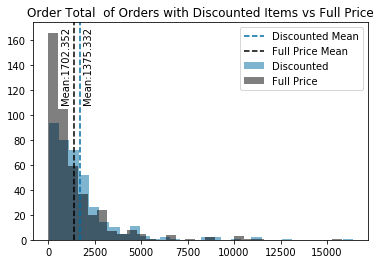

In [112]:
# Plot the re-sampled data

# # IF want to take smaller sample from population:

# pop_samp_disc = np.random.choice(pop_samp_disc,1000)
# pop_samp_full = np.random.choice(pop_samp_full, 1000)
with plt.style.context(('tableau-colorblind10')):
    fig = plt.figure()
    
    plt.title('Order Total  of Orders with Discounted Items vs Full Price')
    
    plt.hist(arrA,alpha = 0.5, bins=30,label='Discounted')
    plt.hist(arrB,color='black', alpha = 0.5, bins=30,label='Full Price')

    # Adding annotations
    meanD = round(np.mean(arrA),3)
    meanS = round(np.mean(arrB),3)
    
    plt.axvline(meanD, linestyle='--',label='Discounted Mean')
    plt.text(meanD-1000,165,f'Mean:{meanD}',rotation=90)
    
    plt.axvline(meanS,color='k',linestyle='--',label='Full Price Mean')
    plt.text(meanS+500,165,f'Mean:{meanS}',rotation=90)


    plt.legend()
    plt.show()

# Run normality testing
# stat,p = normaltest(pop_samp_full)
# print(f'Normality: stat ={stat}, p = {p}')

# Run ttest
# tstat,tp = stats.ttest_ind(arrA, arrB)
# print(f'T-test: stat ={tstat}, p = {tp}')#tstat,tp
# ax.text(

_________

# **Hypothesis 3**
> **Does the time of year affect quantity of items sold?**

- $H_1$ = The month an order is placed relates to either a higher or lower mean quantity of items sold.
- $H_0$ = The month of an order has no affect on the mean quantity of items sold.

<br>



## ***H3, Aim 1.1 : To select the proper dataset for analyiss  and generate data groups for testing.***

#### Importing Method
- Use sqlalchemy to create engine to connect to Northwind_small.sqlite.<br>
```python
df_ord = pd.read_sql_query("SELECT * FROM OrderDetail JOIN [Order]  ON [Order].Id = OrderDetail.OrderId", engine)```


In [113]:
# Import librairies
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.orm import Session, sessionmaker

# from google.colab import drive
# drive.mount('/content/drive/', force_remount=True)

# filepath = '/content/drive/My Drive/Colab Notebooks/datasets/Northwind_small.sqlite'
filepath = 'Northwind_small.sqlite'
engine = create_engine('sqlite:///'+filepath,echo=True)
inspector = inspect(engine);

# df_employee = pd.read_sql_query("SELECT Id, Title, LastName, HireDate , BirthDate  FROM [EMPLOYEE]", engine )
# df_cust_ord = pd.read_sql_query("SELECT *FROM [Order] JOIN [Customer] ON [Customer].Id = [Order].CustomerId", engine)
print(inspector.get_table_names())

2019-04-09 20:38:40,793 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-04-09 20:38:40,793 INFO sqlalchemy.engine.base.Engine ()
2019-04-09 20:38:40,794 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-04-09 20:38:40,795 INFO sqlalchemy.engine.base.Engine ()
2019-04-09 20:38:40,797 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2019-04-09 20:38:40,797 INFO sqlalchemy.engine.base.Engine ()
['Category', 'Customer', 'CustomerCustomerDemo', 'CustomerDemographic', 'Employee', 'EmployeeTerritory', 'Order', 'OrderDetail', 'Product', 'Region', 'Shipper', 'Supplier', 'Territory']


### Extract SQL tables and clean/combine 
- Original extract used for analysis.
- Secondary method was added to export a larger csv for external plotting. 

In [114]:
# Extractiong of specific, required data from database. 
df_ord = pd.read_sql_query("SELECT * FROM OrderDetail JOIN [Order]  ON [Order].Id = OrderDetail.OrderId", engine)
# df_ord = pd.concat([df_ord, df_employee['Title']], axis=1)
df_ord.columns

2019-04-09 20:38:40,807 INFO sqlalchemy.engine.base.Engine SELECT * FROM OrderDetail JOIN [Order]  ON [Order].Id = OrderDetail.OrderId
2019-04-09 20:38:40,808 INFO sqlalchemy.engine.base.Engine ()


Index(['Id', 'OrderId', 'ProductId', 'UnitPrice', 'Quantity', 'Discount', 'Id',
       'CustomerId', 'EmployeeId', 'OrderDate', 'RequiredDate', 'ShippedDate',
       'ShipVia', 'Freight', 'ShipName', 'ShipAddress', 'ShipCity',
       'ShipRegion', 'ShipPostalCode', 'ShipCountry'],
      dtype='object')

In [115]:
# Dropping unwanted columns
df_ord.drop(['OrderId', 'ShipName',
             'ShippedDate', 'RequiredDate',
             'ShipVia','ShipAddress',
             'RequiredDate','ShippedDate',
             'ShippedDate', 'ShipCity',
             'ShipCountry','ShipRegion',
             'Freight'],inplace=True, axis=1)

# relabel the Id column so they have unique names
df_ord.columns = ['Id', 'ProductId', 'UnitPrice',
                  'Quantity', 'Discount', 'OrderId',
                  'CustomerId', 'EmployeeId',
                  'OrderDate', 'ShipPostalCode']

#### Calculating new features based on unit pricing (df_price)

In [116]:
#Apply calc_product_price to every row 
df_price = df_ord.apply(
    lambda x: calc_product_price(
        x),axis=1)

# Apply_calc_order_total to every row
df_price = df_price.apply(
    lambda x: calc_order_total(
        x,df_price), axis=1)  

# Display output
df_price.describe().round()

,ProductId,UnitPrice,Quantity,Discount,OrderId,EmployeeId,price,OnSale,discounted_order,order_total
count,2155.0,2155.0,2155.0,2155.0,2155.0,2155.0,2155.0,2155.0,2155.0,2155.0
mean,41.0,26.0,24.0,0.0,10659.0,4.0,587.0,0.0,0.0,1854.0
std,22.0,30.0,19.0,0.0,241.0,2.0,969.0,0.0,0.0,1961.0
min,1.0,2.0,1.0,0.0,10248.0,1.0,5.0,0.0,0.0,12.0
25%,22.0,12.0,10.0,0.0,10451.0,2.0,147.0,0.0,0.0,634.0
50%,41.0,18.0,20.0,0.0,10657.0,4.0,338.0,0.0,0.0,1337.0
75%,60.0,32.0,30.0,0.0,10862.0,7.0,656.0,1.0,1.0,2222.0
max,77.0,264.0,130.0,0.0,11077.0,9.0,15810.0,1.0,1.0,16388.0


#### Adding Datetime columns for day of week and month


In [117]:
#convert dates to datetime
df_price['OrderDate'] = pd.to_datetime(
                    df_price.OrderDate )

(df_price.OrderDate.sort_values().min(),
 df_price.OrderDate.sort_values().max())# seeing date range

(Timestamp('2012-07-04 00:00:00'), Timestamp('2014-05-06 00:00:00'))

In [118]:
# create columns for day of week and month
df_price['OrderDate'] = pd.to_datetime(
                    df_price.OrderDate) 

df_price['week_day'] = df_price['OrderDate'].dt.dayofweek
df_price['month'] = df_price['OrderDate'].dt.month

# df_price.info()

In [119]:
# Defining criteria for dividing the calendar yaer
criteria = df_price['month'] <= 6 # boolean selector used to select parts of df for possible plotting options

#drop duplicate orders based on OrderId to not inflate or deflate order_total mean
# split in two for exploring subsets
df_month6 = df_price.loc[criteria,
                         ['month','order_total',
                          'Discount','OrderId']
                        ].drop_duplicates(['OrderId'])

df_month12 = df_price.loc[~criteria,
                          ['month','order_total',
                           'Discount','OrderId']
                         ].drop_duplicates(['OrderId'])

#Did use this variable
total_order = pd.concat(
                [df_month6['order_total'],
                df_month12['order_total']],axis=0)

# verifying correct lengths
len(total_order) == (len(df_month6['order_total']) 
                   + len(df_month12['order_total']))

True

#### Selecting out final working dataframe for testing. 

In [120]:
df_year = df_price.loc[:,
                       ['month', 'order_total',
                        'Discount', 'OrderId']
                       ].drop_duplicates(['OrderId'])
df_year.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 830 entries, 0 to 2130
Data columns (total 4 columns):
month          830 non-null int64
order_total    830 non-null float64
Discount       830 non-null float64
OrderId        830 non-null int64
dtypes: float64(2), int64(2)
memory usage: 32.4 KB


#### Create a dictionary containing keys and values representing months to assist in plotting and testing

In [121]:
#make list of month names (strings) for labels
months = ['jan','feb',
          'mar','apr',
          'may' ,'jun',
          'jul', 'aug',
          'sep', 'oct',
          'nov', 'dec'
         ]
#make corresponding list of integers from 1 = 'jan' through 12 = 'dec'
month_code = list(range(1,len(months)+1))
month_dict = dict(zip(month_code,months)) # zip the two into a dictionary
month_dict.items()

dict_items([(1, 'jan'), (2, 'feb'), (3, 'mar'), (4, 'apr'), (5, 'may'), (6, 'jun'), (7, 'jul'), (8, 'aug'), (9, 'sep'), (10, 'oct'), (11, 'nov'), (12, 'dec')])

In [122]:
# Add month name
for k,v in month_dict.items():
      df_year.loc[(df_year['month'] == k), 'month_name'] = v 
        
df_yearM = df_year.copy()
df_yearM.head(3), df_yearM.tail(3)

(   month  order_total  Discount  OrderId month_name
 0    7       440.0        0.0     10248      jul   
 3    7      1863.4        0.0     10249      jul   
 5    7      1552.6        0.0     10250      jul   ,
       month  order_total  Discount  OrderId month_name
 2124    5      498.100      0.15     11075      may   
 2127    5      792.750      0.25     11076      may   
 2130    5     1255.721      0.20     11077      may   )

### def_drop_regex

In [123]:
def df_drop_regex(DF, regex_list):
    '''Use a list of regex to remove columns names. Returns new df.
    
    Parameters:
        DF -- input dataframe to remove columns from.
        regex_list -- list of string patterns or regexp to remove.
    
    Returns:
        df_cut -- input df without the dropped columns. 
        '''
    df_cut = DF.copy()
    
    for r in regex_list:
        
        df_cut = df_cut[df_cut.columns.drop(list(df_cut.filter(regex=r)))]
        print(f'Removed {r}\n')
        
    return df_cut

### Secondary extraction method for larger dataset to export to csv

In [124]:
# Extracting additional information to export for external plotting. 
DB_Order = pd.read_sql_table('Order',engine);
DB_OrderDetail = pd.read_sql_table('OrderDetail',engine);
print(f"DB_Order columns:{DB_Order.columns}n\n DB_OrderDetail columns: {DB_OrderDetail.columns}");

2019-04-09 20:38:54,029 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2019-04-09 20:38:54,029 INFO sqlalchemy.engine.base.Engine ()
2019-04-09 20:38:54,031 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='view' ORDER BY name
2019-04-09 20:38:54,032 INFO sqlalchemy.engine.base.Engine ()
2019-04-09 20:38:54,033 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Order")
2019-04-09 20:38:54,034 INFO sqlalchemy.engine.base.Engine ()
2019-04-09 20:38:54,037 INFO sqlalchemy.engine.base.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = 'Order' AND type = 'table'
2019-04-09 20:38:54,038 INFO sqlalchemy.engine.base.Engine ()
2019-04-09 20:38:54,040 INFO sqlalchemy.engine.base.Engine PRAGMA foreign_key_list("Order")
2019-04-09 20:38:54,041 INFO sqlalchemy.engine.base.Engine ()
2019-04-09 20:38:54,041 INFO sqlalchemy.engine.base.Engine SELECT sql FROM  

In [125]:
# TAKE  DB_Orderm rename index, remove unwanted columns
DB_Order.rename({'Id':'OrderId','OrderDate':'OrderPlaced'},axis=1,inplace=True)

# Drop unwanted columns from DB_Orde to make df_Order
regex_to_drop = ['Date','Freight']

df_Order = df_drop_regex(DB_Order, regex_to_drop)
df_Order.rename({'OrderPlaced':'OrderDate'},axis=1,inplace=True)
# df_Order.head()

Removed Date

Removed Freight



In [126]:
# MERGING IMPORT DB_OrderDetail and cleaned df_Order
df_merged = DB_OrderDetail.merge(df_Order, on='OrderId',copy=True)

In [127]:
# Renaming dataframes for consistency
df_order_geo = df_merged.copy()
# df_order_geo.info()

In [128]:
# # Remove some columns from df_order_geo

# df_order_geo.drop(['OrderId', 'ShipName', 'ShippedDate', 'RequiredDate', 'ShipVia','ShipAddress',
#              'RequiredDate','ShippedDate', 'Freight'],inplace=True, axis=1)
# # relabel the Id column so they have unique names
# df_order_geo.rename(columns={'Id':'OrderId_'},inplace=True )
# df_order_geo.info()
# # print(f'df_ord.info():\n {df_ord.info()}\n\ndf_order_geo.info():\n{df_order_geo.info()}')


In [129]:
#Apply calc_product_price to every row 
df_price_geo = df_order_geo.apply(lambda x: calc_product_price(x),axis=1)

# Apply_calc_order_total to every row
df_price_geo = df_price_geo.apply(lambda x: calc_order_total(x,df_price_geo), axis=1)  
# df_price_geo.info()

In [130]:
#convert dates to datetime
df_price_geo['OrderDate'] = pd.to_datetime(df_price_geo.OrderDate )
df_price_geo.OrderDate.agg(['mean','max','min'])

max   2014-05-06
min   2012-07-04
Name: OrderDate, dtype: datetime64[ns]

In [131]:
# Create columns for day of week and month
df_price_geo['OrderDate'] = pd.to_datetime(df_price_geo.OrderDate)

df_price_geo['week_day'] = df_price_geo['OrderDate'].dt.dayofweek
df_price_geo['month'] = df_price_geo['OrderDate'].dt.month

# df_price_geo.info()

In [132]:
# Make list of month names to map onto dataframe.
months = ['jan','feb', 'mar', 'apr', 'may' , 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']#creating label names
# month_code =
month_dict = dict(zip( list(range(1,len(months)+1)),months)) # zip the two into a dictionary

# MAP THE MONTH_DICT ONTO NEW COLUMN month_name
df_price_geo['month_name'] = df_price_geo['month'].map(month_dict)
df_price_geo['month_name'].value_counts()

apr    261
mar    255
jan    237
feb    201
dec    195
oct    179
nov    155
may    155
aug    153
sep    152
jul    136
jun     76
Name: month_name, dtype: int64

In [133]:
# Save df_price_Geo 
# Save figure of save_for_user is True
if save_for_user == True:
# save = input(prompt='Would you like to export the dataframe above? (y/n)\n')
# if save.lower()=='y':
    filename ='df_H3_price_w_dates_products.csv'
    df_H3_price_w_dates_products = df_price_geo.copy()
    df_H3_price_w_dates_products.to_csv(data_filepath+filename)
    print(f'df_price exported and saved as {filename}...')
    print(f'if you are running this on Colab:...\nOpen File sidebar, click Refresh, right click on {filename} to Download.')
    
    filename ='df_H3_price_w_dates_orders.csv'
    df_H3_price_w_dates_orders = df_H3_price_w_dates_products.drop_duplicates(subset=['OrderId'])
    df_H3_price_w_dates_orders.to_csv(data_filepath+filename)
    print(f'if you are running this on Colab:...\nOpen File sidebar, click Refresh, right click on {filename} to Download.')

else:
    print('No .csv exported.')
    
    
# print(f'The cell above is currently commented out, uncomment to export csv')


No .csv exported.


In [134]:
# df_price_geo.info()

### EDA
 - Extraction workflows merge here. 
 - define uselful functions for visualizations
 - Plotting and visualizing features

In [135]:
# Picking which iteration of df_price to use 
df_year = df_price_geo.copy()
#df_year = df_priceM

In [136]:
#- Adding df_year_orders = df_price_geo should ensure that the rest of mike's code runs
df_year_orders = df_price_geo.drop_duplicates(subset=['OrderId']).copy()
df_year_orders.set_index('OrderId',inplace=True,verify_integrity=True)
# df_year_orders.info()

In [137]:
# Drop unneeded and misleading formerly product-associated columns
vars_to_drop = ['EmployeeId','ShipVia','ShipAddress','ShipRegion','ProductId','ShipName','Id','price','OnSale']
df_year_orders.drop(vars_to_drop,axis=1,inplace=True)
# df_year_orders.info()

### plot initial order totals by month

In [138]:
# Declare variables to be plotted
df_year_orders.loc[df_year_orders['Discount'] > 0,
                   'Is Discounted?'] = True

df_year_orders.loc[df_year_orders['Discount'] == 0,
                   'Is Discounted?'] = False
x = df_year_orders['month']
y = df_year_orders['order_total']
data = df_year_orders 
ticks = [v.title() for v in month_dict.values()] 
title = 'Order Totals:\n Discounts Vs No Discount'
leg_label = 'Is Discounted?'

In [139]:
with plt.style.context('dark_backm'):

    make_violinplot( x, y, leg_label, data,
                    ticklabels=ticks, title=title,
                    leg_label=leg_label)
if save_for_user == True:
    plt.savefig(fig_filepath+'stripplot - order totals per month.png', dpi=300)

NameError: name 'make_violinplot' is not defined

In [ ]:
make_stripplot(x,y,title,hue,ticks)
if save_for_user == True:
    plt.savefig(fig_filepath+'stripplot - order totals per month.png', dpi=300)
    

## ***H3, Aim 2 : Test for assumptions of normality and equal variance, then choose test***
---




* ***Aim 2: Select the appropriate t-test based on tests for the assumptions of normality and homogeneity of variance.***
    1. **Test for Normality**<br>
        - [Normaltest/ D’Agostino and Pearson’s](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html)
<br>
        ```scipy.stats.normaltest```
        - Shapiro-Wilik Test<br>
        ```scipy.stats.shapiro```
    2. **Test for Homogeneity of Variance**<br>
        - [Levene's Test](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.levene.html)<br>         ```scipy.stats.levene```
    3. **Choose appropriate test based upon 1. and 2.** 
        - [Mann Whitney U Test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html)<br>  - non parametric equivalent of ANOVA)<br>
    ```stats.mannwhitneyu```<br>
        - Normal: 2 sample t-test
        - Welch's t-test (Jeff)
        
    4.  Calculate effect size, post-hoc tukeys tests.
        - Effect size: [cohen's d](https://stackoverflow.com/questions/21532471/how-to-calculate-cohens-d-in-python)
          
* ***Aim 3: To perform post-hoc pairwise comparisons for level of discount***      
    5. If significant result, follow up with post-hoc tests
        - [Tukey's](https://www.statsmodels.org/stable/generated/statsmodels.stats.multicomp.pairwise_tukeyhsd.html)
        ```statsmodels.stats.multicomp.pairwise_tukeyhsd```


#### Histograms month vs all months

In [ ]:
draw_histograms(df_year, 'month', month_dict, 4, 3)

In [ ]:
# draw_histograms_from_sample(df_year_orders, 'month', month_dict, 4, 3)
# df_year_orders[['Quantity','Discount','price','order_total']].describe()

In [ ]:
# df_year_orders.groupby('month_name').agg(['mean','std','min','max','count'])

### Aim 2.1: Test for Normality

In [ ]:
# create a dict to test stats
dict_to_test ={}
for month in list(df_year_orders['month_name'].unique()):
    dict_to_test[month] = df_year_orders.groupby('month_name').get_group(month)

In [ ]:
for k,v in dict_to_test.items():
    print(f'{k} has: {len(v)} rows.')
# len(dict_to_test.values())
# dict_to_test.keys()

In [ ]:
# Create H3_tests list to receive all test results for this hypothesis:
H3_tests = [['Group:','TestName','Test Purpose','stat','p','p<.05?']  ]

In [ ]:
# Use normaltest for D'Agostino Pearson's test
from scipy.stats import normaltest

# Recursively go through months and then test each monthths
for month,  df  in dict_to_test.items(): #month = key, df = values

    arrA = dict_to_test[month]['order_total']

    #1. Test for normality
    test_purpose = 'Normality'
    test_to_run = 'normaltest'

    arrA = np.array(arrA)
    statA, pA = eval(test_to_run)(arrA)

    # Append the result
    H3_tests.append([month, test_to_run, test_purpose ,statA, pA, pA<0.05])

# Adding a test for the year as a whole. 
arrB = np.array(df_year_orders['order_total'])
stat, p = eval(test_to_run)(arrB)

# Append the results.
H3_tests.append(['Total Pop', test_to_run, test_purpose,stat, p,p<0.05])

# Display Results
H3_results_norm = list2df(H3_tests)
H3_results_norm

### Aim 2.2: Test for Homogneity of Variance
- Levenes Test

In [ ]:
from scipy.stats import levene

for month,  df  in dict_to_test.items(): #month = key, df = values
    
    # Create array A for month and array B for all other months.
    arrA = dict_to_test[month]['order_total']
    arrB = df_year_orders[df_year_orders['month_name']!= month]['order_total']
  
    arrA = np.array(arrA)
    arrB = np.array(arrB)
    
    
    #1. Test for equal variance. 
    test_to_run = 'levene'
    test_purpose = 'Equal Variance'

    # Run Levene's test
    stat, p = eval(test_to_run)(arrA,arrB,center='median')
    
    # Append Results
    H3_tests.append([f'{month} vs. Other Months', test_to_run, test_purpose ,stat, p, p<0.05])

list2df(H3_tests)

### Aim 2.3. Choose Appropriate Test Based on Testing Assumptions

- Note: We did not meet the criteria for normality or equal variance. 
- We also have more than 2  groups, so cannot do the Mann-Whitney U test. 
- Decided to run both a M.W.U test and Tukey's
    - MWU to analyze each month vs the other months.
    - Tukey's for pairwise comparisons between months


#### Mann-Whitney U test of months vs year


In [ ]:
from scipy.stats import mannwhitneyu

for month, df  in dict_to_test.items(): #month = key, df = values

    arrA = dict_to_test[month]['order_total']
    arrB = df_year.loc[df_year['month_name']!= month,'order_total']

    test_to_run = 'mannwhitneyu'
    test_purpose = 'Hi sig.'

    arrA = np.array(arrA).reshape(-1,1)
    arrB = np.array(arrB).reshape(-1,1)

    stat, p = eval(test_to_run)(arrA,arrB,alternative='two-sided')
    
    print(f'{month}:',stat, p)
    
    H3_tests.append([f'{month} vs. Other Months', test_to_run, test_purpose ,stat, p, p < .05])

list2df(H3_tests)

#### Calculating effect size wiht Cohen's d

In [ ]:
# Calculating effect sizes
d_dict = {}
for month,  df  in dict_to_test.items(): #month = key, df = values

    arrA = dict_to_test[month][['order_total']]
    arrB = df_year[df_year['month_name']!= month]['order_total']

    test_to_run = 'Cohen_d'
    test_purpose = 'efect Size'

    arrA = np.array(arrA)
    arrB = np.array(arrB)

    d = Cohen_d(arrA, arrB)
    
    d_dict[month] = d
    
    print(f'{month}:',d)
    H3_tests.append([f'{month}', test_to_run, test_purpose ,stat])
list2df(H3_tests)

In [ ]:
# Export H3 test resutls.
table_H3_test_results = list2df(H3_tests)
if save_for_user==True:
    table_H3_test_results.to_csv(data_filepath+'table_H3_test_results.csv')
    table_H3_test_results.round(4).to_html(data_filepath+'table_H3_test_results.html')

### Use Tukey's Pairwise Multiple Comparison test.
```statsmodels.stats.multicomp.pairwise_tukeyhsd```

In [ ]:
# Importing tukey's test
from statsmodels.stats.multicomp import pairwise_tukeyhsd as tukey

# Defome the dataframe containing column of interest and group labels. 
df_test_hypothesis = df_year_orders[['order_total','month_name','week_day']]
grp_labels = df_test_hypothesis['month_name']

# Run tukey's test
tukey_results = tukey(df_test_hypothesis['order_total'], grp_labels, 0.05)


# Save the results into a dataframe
table_H3_tukey = tukey_table(tukey_results)

# save for user
if save_for_user==True:
    table_H3_tukey.to_csv(data_filepath+'table_H3_tukey.csv')
    table_H3_tukey.round(4).to_html(data_filepath+'table_H3_tukey.html')


# Display any significant pairwise comparisons. 
display(table_H3_tukey.loc[table_H3_tukey['reject']==True])

**There were no significant pairwise comparisons.**

#### SAVE THIS: using groupby to get mean, sem, for plotting

In [ ]:
# WANT TO CALCULATE MEAN AND SEM FOR BAR PLOT FOR DF
# Calc Standard Error of the Mean for PLotting.
from scipy.stats import sem

d_plot={}
d_plot['mean'] = df_year_orders.groupby(['month'])['order_total'].mean()
d_plot['sem'] = df_year_orders.groupby(['month'])['order_total'].sem()
d_plot['std'] = df_year_orders.groupby(['month'])['order_total'].std()
d_plot['n'] = df_year_orders.groupby(['month'])['order_total'].count()

df_plot = pd.DataFrame.from_dict(d_plot)

# Convert month index to month_num column
df_plot['month_num'] = df_plot.index

# Use month_dict to get months labeled with names
df_plot['month_name']=df_plot['month_num'].map(month_dict)
df_plot.set_index('month_name',drop=False,inplace=True)

In [ ]:
display(df_plot)

In [ ]:
# export table with mean and sem for all months
H3_mean_sem = [['H#','Group','mean','sem','std','n']]

for month in df_plot.index:
   
    h = 'H3'
    group = month
    mo_mean = df_plot.loc[month,'mean']
    mo_sem = df_plot.loc[month,'sem']
    mo_std = df_plot.loc[month,'std']
    n = df_plot.loc[month,'n']
    H3_mean_sem.append([h,group,mo_mean,mo_sem,mo_std,n])

table_H3_mean_sem = list2df(H3_mean_sem)

# Export csv if user sets save_for_user to True
if save_for_user==True:
    table_H3_mean_sem.to_csv(data_filepath+'table_H3_mean_sem.csv')    
    table_H3_mean_sem.round(2).to_html(data_filepath+'table_H3_mean_sem.html')    
    
display(table_H3_mean_sem.round())

In [ ]:
# display(table_H3_test_results)
# display(table_H3_tukey)
display(table_H3_test_results)

In [ ]:
# Display final results for H3_tests
# H3_tests_table = list2df(H3_tests)
table_H3_test_results.groupby('TestName').get_group('mannwhitneyu')

## ***Conclusions for Hypothesis 3:***
1. **We first used D'Agostino & Perason's test (normaltest) to check for normal distributions**
    -  Both groups had p-values very far below our $\alpha=0.05$  (Rows 0,1 below)
        - We reected the null hypothesis that the groups came from a population with a normal distribution. 
2. **We tested for equal variances using Levene's test. **
    - Levene's test had a signifcant p-value, so we rejected the hypothesis that the groups have equal variances
    
3. **We then concluded we need a non-parametric test, so we first used the Mann-Whitney U test to compare each month vs the other 11 months**. 
    -  Several months were significantly different than the rest of the year:
        - Jul, Aug, Sep, Feb, Mar, Apr
    -  
4. **We then did pairwise comparisons of all months using Tukey's test**
    - We could not reject the null hypothesis that month affects the quantity sold. 
    - It is difficult to interpret the contradicting results of the Mann Whitney U and the Tukey's test.
        - But since Tukey's test corrects for multiple comparisons, it should be trusted over M.W.U.



## BOOKMARK- SUMMARY FIGURE h3

In [ ]:
#  ax.bar(x=df_plot.index, height= df_plot['mean'], yerr=df_plot['sem'])

with plt.style.context('dark_background'):
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(1,1,1)
    
    color = ['red','orange','yellow','green','blue','indigo','violet']
    
    err_kws = {'ecolor': 'w', 'capsize':5,
               'elinewidth': 2 ,'capthick': 2}
    
    fontTitle = {'fontfamily':'serif',
               'fontweight':'medium',
               'fontsize':16}
    
    fontAxis = {'fontfamily':'serif',
               'fontweight':'medium',
               'fontsize':12}
    labels = [str(i).title() for i in df_plot.index]
    ax.bar(x = labels,width=0.6, height = df_plot['mean'], yerr = df_plot['sem'], error_kw=err_kws,
          edgecolor='white', linewidth = 2,color = color)
    
    ax.set_title('Order Totals By Month',fontdict=fontTitle)
    ax.set_ylabel('Average Order Total',fontdict=fontAxis)
    ax.set_xlabel('Month', fontdict=fontAxis)
    
    plt.show()

In [ ]:
# Save figure of save_for_user is True
if save_for_user == True:
    fig.savefig(fig_filepath+'H3_Month_Bar_mean_sem_black.png',dpi=300,facecolor='k')

___
# Hypothesis 4 

> Do different countries respond to discounts more than others? 

$H_1$: Different countries purchase different quantities of discounted vs non discounted products. 

$H_0$: All countries purchase the same quantities of discounted vs non discounted products. 

**Specific Aims:**

* ***Aim 1:To select the proper dataset for analysis, perform EDA, and generate data groups for testing.***
    - Used sqlalchemy and pandas.read_sql_query()
    query = 

* ***Aim 2: Select the appropriate t-test based on tests for the assumptions of normality and homogeneity of variance.***
    1. **Test for Normality**
        - D'Agostino-Pearson's normality test<br>
        ```scipy.stats.normaltest```
        - Shapiro-Wilik Test<br>
        ```scipy.stats.shapiro```
    2. **Test for Homogeneity of Variance**
        - Levene's Test<br>
         ```scipy.stats.levene```

    3. **Choose appropriate test based upon 1. and 2.** 


* ***Aim 3: To perform post-hoc painrwise comparison testing to determine which level of discounts affect quantity and if any discount has a greater effect than the others.***
     - Tukey's test for multiple pairwise comparisons


## ***H4, Aim 1.1 : To select the proper dataset for analyiss  and generate data groups for testing.***

#### Importing Method
- Used sqlalchemy to create engine to connect to Northwind_small.sqlite.
- Read tables directly into dataframes<br>
```python
DB_Order = pd.read_sql_table('Order',engine);
DB_OrderDetail = pd.read_sql_table('OrderDetail',engine);```



In [ ]:
## Extract Order and OrderDetail Tables
DB_Order = pd.read_sql_table('Order',engine);
DB_OrderDetail = pd.read_sql_table('OrderDetail',engine);
print(f"DB_Order columns:{DB_Order.columns}",'n\n'
      "DB_OrderDetail columns:",'n\n'
     f"{DB_OrderDetail.columns}")

In [ ]:
# Rename Id in DB_Order, rename index,and remove unwanted columns
DB_Order.rename({'Id':'OrderId','OrderDate':'OrderPlaced'},axis=1,inplace=True)

# Drop unwanted columns from DB_Orde to make df_Order
regex_to_drop = ['Date','Freight']

df_Order = df_drop_regex(DB_Order, regex_to_drop)
df_Order.rename({'OrderPlaced':'OrderDate'},axis=1,inplace=True)
df_Order.head(5)

### Processing Data to Generate Features


In [ ]:
# CALCULATING THE SUB TOTALS AMD ORDER TOTALS
df_merged = DB_OrderDetail.merge(df_Order, on='OrderId',copy=True)
df_order_geo = df_merged.copy()

#Apply calc_product_price to every row 
df_price_geo = df_order_geo.apply(lambda x: calc_product_price(x), axis=1)

# Apply_calc_order_total to every row
df_price_geo = df_price_geo.apply(lambda x: calc_order_total(x,df_price_geo), axis=1) 

In [ ]:
#convert dates to datetime
df_price_geo['OrderDate'] = pd.to_datetime(df_price_geo.OrderDate )
df_price_geo.OrderDate.agg(['mean','max','min'])

In [ ]:
# Create columns for day of week and month
df_price_geo['OrderDate'] = pd.to_datetime(df_price_geo.OrderDate)

df_price_geo['week_day'] = df_price_geo['OrderDate'].dt.dayofweek
df_price_geo['month'] = df_price_geo['OrderDate'].dt.month

# df_price_geo.info()

In [ ]:
# Make list of month names to map onto dataframe.
months = ['jan','feb', 'mar', 'apr', 'may' , 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']#creating label names

month_dict = dict(zip( list(range(1,len(months)+1)),months)) # zip the two into a dictionary

# MAP THE MONTH_DICT ONTO NEW COLUMN month_name
df_price_geo['month_name'] = df_price_geo['month'].map(month_dict)
# df_price_geo['month_name'].value_counts()

In [ ]:
#renamed df for ease of typing & it is a comprehensize starting point
df = df_price_geo
df.head()

### ***H4, Aim 1.2: Exploring and Engineering features to best address hypothesis.***
- difference between quantity bought with and without discount

In [ ]:
# Separate each country's sales data into a dictionary in order to create New features for global discount effects on sales
D_country = {}

countries = list(df['ShipCountry'].unique())

for country in countries:
    
    #check for discounts    
    check_if_discounted = len(df.groupby('ShipCountry').get_group(country)['OnSale'].unique())
    
    if check_if_discounted < 2:
        print(f'{country} did not have both discounted and non-discounted items.')
        continue
        
    else:
        
        #Organize prices based on sales and fullprice    
        D_country[country]={}

        D_country[country]['df_sale'] = df.loc[df['OnSale']==1].groupby('ShipCountry').get_group(country)
        
        D_country[country]['df_fullprice'] = df.loc[df['OnSale']==0].groupby('ShipCountry').get_group(country) 
        
        #Get total sales
        D_country[country]['price']={}
        D_country[country]['price']['OnSale'] = D_country[country]['df_sale']['price']
        D_country[country]['price']['FullPrice'] = D_country[country]['df_fullprice']['price']
        
        #Get Quantity sold at discount/nondiscount
        D_country[country]['quantity']={}
        D_country[country]['quantity']['OnSale'] = D_country[country]['df_sale']['Quantity']
        D_country[country]['quantity']['FullPrice'] = D_country[country]['df_fullprice']['Quantity']

### Engineered Discount-Preference Features to Explore
- ```Price_Disc-Full```: Sum of all purchases of discounted items minus the sum of all purchases of full price items.
- ```Price_Disc/Total```: Ratio of money spent on discounted products / total money spent on orders. 
- ```Quant_Disc-Full```: Sum of all discounted products' quantities minus sum of all full price products' quantities. 
- ```Quant_Disc/Total```: Ratio of quantities of discounted products / total quantity of all products ordered.
- ```AvgPrice_Disc```: Average price of discounted items purchased (sum(price) / sum(quantity) of discounted items.
- ```AvgPrice_full```: Average price of full price items purchased (sum(price) / sum(quantity) of full price items.

In [ ]:
# Calculate metrics for country-preference for discounted items. 
dC = D_country
results = [['country','Price_Disc-Full','Price_Disc/Total','Quant_Disc-Full',
            'Quant_Disc/Total','AvgPrice_Disc','AvgPrice_Full','AvgPrice/item']]

# For each country:
for c in dC.keys():
    
    # fill in temp list with the names of the data that will be placed in their location. 
    temp = ['country','Price_Disc-Full','Price_Disc/Total','Quant_Disc-Full',
            'Quant_Disc/Total','AvgPrice_Disc','AvgPrice_Full','AvgPrice/item']
    
    calc = dC[c]
    i=0
    temp[i] = c   # country name
    
    i+=1
    temp[i] = (calc['price']['OnSale'].sum()         # price sub
               - calc['price']['FullPrice'].sum())
    i+=1
    temp[i] = (calc['price']['OnSale'].sum()        # price/total 
               / (calc['price']['FullPrice'].sum() 
               + calc['price']['OnSale'].sum()))
    i+=1
    temp[i] = (calc['quantity']['OnSale'].sum()      # quantitty sub
               - calc['quantity']['FullPrice'].sum())
    i+=1
    temp[i] = (calc['quantity']['OnSale'].sum()      # quantity total
               / (calc['quantity']['FullPrice'].sum() 
               + calc['quantity']['OnSale'].sum()))
    i+=1
    temp[i] = (calc['price']['OnSale'].sum()       # average spent on sale 
               / calc['quantity']['OnSale'].sum() )
    i+=1                                           
    temp[i] = (calc['price']['FullPrice'].sum()      # average cost full price 
               / calc['quantity']['FullPrice'].sum()) 
    i+=1
    temp[i] = (calc['price']['FullPrice'].sum()  # average spent on all items
               + calc['price']['OnSale'].sum() 
               / calc['quantity']['FullPrice'].sum() 
               + calc['quantity']['OnSale'].sum())
    results.append(temp)

# Display the engineered features.
df_countries = list2df(results)
df_countries.set_index('country',inplace=True)
df_countries.sort_index()

#### Engineered additional features for comparing countries
- ```AvgOrderPrice```: Mean of all order totals for a country.
- ```PctOf-orders```: The % of all global orders placed by a country. 
- ```PctOf-Income ```: The % of all global income (order_totals) placed by a country. 
- ```orders2-Income```: _Comparing percentage of all orders / percentage on overall income_
- ```DiscountGap```:  Country's AvgPrice_Full - AvgPrice_Discounted. 

In [ ]:
cleaned = pd.DataFrame(df.drop_duplicates(['OrderId']))

# Making average price of sales for each country
df_countries['AvgOrderPrice'] = (cleaned.groupby('ShipCountry')['order_total'].mean())


#The % of all global orders placed by a country. 
df_countries['PctOf-orders'] = round((cleaned.groupby('ShipCountry')['OrderId'].count() 
                                      / cleaned['OrderId'].count().sum()*100),2)

# The % of all global income (order_totals) placed by a country. 
df_countries['PctOf-Income'] = round((cleaned.groupby('ShipCountry')['order_total'].sum()
                                    / cleaned['order_total'].sum()*100),2)

#Checking results, Three countries had no disc.
print(df_countries['PctOf-orders'].sum(),
      df_countries['PctOf-Income'].sum()) 


#comparing percentage of all orders vs percentage on overall income 
df_countries['orders2-Income'] = (df_countries['PctOf-orders'] 
                                / df_countries['PctOf-Income'])

#finding difference between full price and disc price
df_countries['DiscountGap'] = (df_countries['AvgPrice_Full']
                             - df_countries['AvgPrice_Disc'])

In [ ]:
display(df_countries.round(2).sort_index())

In [ ]:
# Add stats to df
# Mean
# Std. Error Mean
# Std. deviation
df_header = df_countries.columns

country_col_means = pd.Series(df_countries.mean(axis=0)) 
country_col_sem = pd.Series(df_countries.sem(axis=0))   
country_col_std = pd.Series(df_countries.std(axis=0)) 

df_country_col_means_sem = pd.DataFrame([country_col_means, country_col_sem,
                        country_col_std],columns=df_header)
df_country_col_means_sem.index = ['mean','sem','std']
df_country_col_means_sem.columns=df_countries.columns
df_country_col_means_sem

In [ ]:
# Save output if save_for_user == True 
if save_for_user==True:
    df_countries.to_csv(data_filepath+'H4_countries_disc_pref_features.csv')
    df_country_col_means_sem.to_csv(data_filepath+'H4_countries_disc_pref_col_means_sem.csv')

# Concatenating df_country and mean sem dataframes. 
df_countries = pd.concat([df_countries, df_country_col_means_sem])

#### Grouping countries based on critical value criteria

In [ ]:
# Create different criteria for exploring and anaqlyzing the current df
# Used crit3 for determining the samples used in hypothesis 4
df_compare = df_countries.drop(['mean','sem','std'], axis=0)
# crit = ((df_compare['orders2-Income'] < 1) 
#         & (df_compare['AvgOrderPrice'] > 1488.357771))

# crit2=((df_compare['AvgPrice_Full']> 25.907391) 
#         & (df_compare['AvgPrice_Disc']> 22.236349))

# .433 is the mean value for Quant_Disc/Total
crit3 = (df_compare['Quant_Disc/Total'] > 0.433410) 

winning = df_compare.loc[crit3]
losing = df_compare.loc[~crit3]
winning.index

In [ ]:
losing.index

In [ ]:
# print(winning.index)

### ***H4, Aim 1.2: Using EDA to decide best metric for hypothesis***

In [ ]:
plt.style.use('default')
with plt.style.context('ggplot'):
    for col in winning.columns:
        fig = plt.figure()

        plt.bar(x=winning.index,
                height=winning[col],
                yerr=df_country_col_means_sem.loc['sem',col])

        ax = fig.gca()
        ax.set_xticklabels(winning.index, rotation=75)
        ax.set_ylabel(col)
        ax.axhline(y=0,color='w',ls=':',lw=1)
        plt.tight_layout

In [ ]:
# print("this cell was error'd on colab")
# # make_stripplot(df_countries,y=df_countries)

In [ ]:
plt.style.use('ggplot')
df_country_plot = df_countries.drop(['sem','mean','std'],axis=0)
for col in df_countries.columns:
    fig = plt.figure(figsize=(8,6))

    plt.bar(x=df_countries.index, height=df_countries[col],yerr=df_country_col_means_sem.loc['sem',col])#,**bar_kws)
    ax = fig.gca()
    ax.set_xticklabels(df_countries.index, rotation=75,fontsize=10)
    ax.set_title(col)
    ax.set_ylabel(col)
    plt.tight_layout

# Hypothesis 4 > Chosen Specific Hypothesis: 
> Do countries that buy discounted items in higher-than-average quantities spend more money (have higher order totals)?


- $H_1$: Orders shipped to countries where average orders contain higher than average amounts of discounted items per order spend more per order on average than other countries.

- $H_0$: Orders shipped to countries where average orders contain higher than average amounts of discounted items per order spend the same per order on average than other countries.


  - I am defining countries with higher than average discount prices as the following:
   Brazil, Belgium, Austria', Mexico, USA, Sweden, Spain, Ireland, Canada, Denmark.
  
  

In [ ]:
df_c = df.drop_duplicates('OrderId')
df_c.set_index('OrderId',inplace=True)
# df_c.head()

### Add three more features for easy analysis,
- column 'Abovecrit' 
    - Boolean value for all countries whose discounted items/total order, is above average for all countries
- column 'AbovecritGroups'
    - subset 'Abovecrit' into 0 for all countries below critical value, and a unique categorical number for each country above.
- column 'CountryCode'
    - a unique code for each country


In [ ]:
# Coding all countries for comparison in a Tukeys test
# Anything With a 1-12 met Criteria in crit3
country_codes = {
    'France':1,'Germany':2,
    'Brazil':3, 'Belgium':13, 
    'Switzerland':4,'Venezuela':14,
    'Austria':5,'Mexico':15,
    'USA':6,'Sweden':7,
    'Finland':16,'Italy':8,
    'Spain':9,'UK':17,
    'Ireland':10,'Portugal':11,
    'Canada':12,'Denmark':18,
    'Poland':19,'Norway':20,
    'Argentina':21
}
# if save_for_user ==True:
#     pd.country_codes.to_csv()
#Unique codes for each country 
df_c.loc[:,'CountryCode'] = df_c['ShipCountry'].map(country_codes)

#Boolean for two groups, Above crit or below
df_c.loc[df_c['CountryCode'] <= 12, 'Abovecrit'] = True
df_c.loc[df_c['CountryCode'] > 12, 'Abovecrit'] = False

#Groups each country above criteria as its own group, rest of pop. isin its own group.
df_c.loc[df_c['CountryCode'] > 12, 'AbovecritGroups'] = 0
df_c.loc[df_c['CountryCode'] <= 12, 'AbovecritGroups'] = df_c['CountryCode']

In [ ]:
# Make series of 'order_totals' for testing against criteria
h4_samp = df_c.groupby('Abovecrit')['order_total'].get_group(1)
h4_pop = df_c.groupby('Abovecrit')['order_total'].get_group(0)

print(f'High Discount Groups: {h4_pop.mean().round(2)}\n Low Discount Group {h4_samp.mean().round(2)}')

h4_pop= pd.DataFrame(h4_pop)
h4_samp= pd.DataFrame(h4_samp)
# (h4_samp.head(),
# h4_pop.head())

### Going back to the original df to test the hypthesis.


In [ ]:
plot_wide_kde_thin_bar(h4_samp.order_total,
                       'High Discount Countries',
                       h4_pop.order_total,
                       'Low Discount Countries')
if save_for_user==True:
    plt.savefig(fig_filepath+'H4_High vs Low Discount Countries KDE bar.png',dpi=300)
plt.tight_layout()

In [ ]:
with plt.style.context(('dark_background')):
    
    sns.set_palette('Dark2')
    fig = plt.figure(figsize=(10,6))
    plt.title('Distribution of total order:\n High Discount vs Low Discount Countries')

    disc = h4_samp['order_total']
    full = h4_pop['order_total']
    label = 'Low Discount Group'
    
    plt.hist(full, alpha = 0.8, bins=30,label=label)
    plt.hist(disc, alpha = 0.5, bins=30,label='High Discount Group')

    # Adding annotations
    meanD = round(np.mean(disc),3)
    meanF = round(np.mean(full),3)
    
    plt.axvline(meanD, color='green',linestyle='--',label='Discounted Mean')
    plt.text(meanD,190,f'Mean:{meanD}',rotation=270,fontweight='medium')
    
    plt.axvline(meanF,color='white',linestyle='-',label='Full Price Mean')
    plt.text(meanF, 190, f'Mean:{meanF}',rotation=270,fontweight='medium')

    plt.xlabel('order_total')
    plt.ylabel('Counts')
    plt.legend()
    plt.show()

## ***H4, Aim 2 : Test for assumptions of normality and equal variance, then choose test***
---



In [ ]:
H4_tests = [[
    'Group:',
    'TestName',
    'Test Purpose',
    'stat','p',
    'p < .05'
]]

In [ ]:
from scipy.stats import normaltest
# Test for normality

test_purpose = 'Normality'
test_to_run = 'normaltest'

arrA = h4_samp.order_total
arrB = h4_pop.order_total
arrA = np.array(arrA)
arrB = np.array(arrB)

statA, pA = eval(test_to_run)(arrA)
stat, p = eval(test_to_run)(arrB)

print('samp:', statA, pA,
      '\n''pop:',stat,p)

H4_tests.append(['Sample', test_to_run, 
                 test_purpose , statA,
                 pA, pA < .05])

H4_tests.append(['Total Pop', test_to_run, 
                 test_purpose, stat, p,
                 p < .05])

### Check variance 
- levenes test

In [ ]:
from scipy.stats import levene

# Levenes test for testing homogeneity of variance
# Choose this over Bartlett's due to  dev. from normality
# Set to center='median' (default) because of skewed dist,
# Use 'mean' for symetrical distribution
# Use trimmed for heavy tailed distributions

arrA = h4_samp.order_total
arrB =h4_pop.order_total

test_to_run = 'levene'
test_purpose = 'Equal Variance'

arrA = np.array(arrA)
arrB = np.array(arrB)

stat, p = eval(test_to_run)(arrA,arrB,
                            center='median')
print('sample and pop:', stat,p)

H4_tests.append(['sample & pop', test_to_run,
                 test_purpose ,stat, p, p < .05])

## T-test
- Both sample and population are not normal and dont have equal variance.
- use Whitney-Mann U

In [ ]:
from scipy.stats import mannwhitneyu
# Mann Whitney U test for non normal distributioin
#Set alternative to 'greater' for one tail test

arrA = h4_samp.order_total
arrB =h4_pop.order_total

test_to_run = 'mannwhitneyu'
test_purpose = 'Hi sig.'

arrA = np.array(arrA)
arrB = np.array(arrB)

stat, p = eval(test_to_run)(arrA,arrB,
                            alternative='greater')
print('sample and pop:', stat, p)

H4_tests.append(['sample and pop', test_to_run,
                 test_purpose ,stat, p, p < .05]) 

In [ ]:
d = Cohen_d(arrA,arrB)
d

In [ ]:
from scipy.stats import ttest_ind

# Run a Welch's one sided t_test for unequal homogeneity
# equal_var is set false, test compensates for this
# Divide in half because it is a one sided test

arrA = h4_samp.order_total
arrB =h4_pop.order_total

test_to_run = "ttest_ind"
test_purpose = 'signifigance'

arrA = np.array(arrA)
arrB = np.array(arrB)

stat, p = eval(test_to_run)(arrA,arrB,
                            equal_var=False)
p = p /2 
print('sample and pop:', stat, p)

H4_tests.append(['sample and pop', test_to_run,
                 test_purpose ,stat, p, p < .05])                   

In [ ]:
# Tukeys with subset of countries against the whole population
# Create labels
# Run Test
# Put results in df
# Checking for any signifigance
from statsmodels.stats.multicomp import pairwise_tukeyhsd as tukey

int_str = [str(x) for x in df_c['AbovecritGroups']]

tukey_results =tukey(df_c['order_total'],int_str, 0.05)
dfH_tukey = pd.DataFrame(data=tukey_results._results_table.data[1:],
                         columns=tukey_results._results_table.data[0])
dfH_tukey.loc[dfH_tukey['reject']==True]
# dfH_tukey

In [ ]:
#Tukey's test with each country compared to each other country

int_str = [str(x) for x in df_c['CountryCode']]

tukey_results = tukey(df_c['order_total'],
                      int_str, 0.05)
dfH_tukey = pd.DataFrame(data=tukey_results._results_table.data[1:],
                         columns=tukey_results._results_table.data[0])
dfH_tukey.loc[dfH_tukey['reject']==True]

In [ ]:
display(list2df(H4_tests))

## Hypothesis 4 Conclusions:
- Our data had significant results for normality and equal variance tests. 
- We therefore ran a Mann Whitney on High Discount COuntries vs Low Discount Countries 
    - We had a significant difference and rejected the null hypothesis 
    

In [ ]:
with plt.style.context('dark_background'):
    fig,ax =plt.subplots(figsize=(12,10))

    sns.violinplot(x = 'ShipCountry', y= 'order_total',
                   data = df,
#                    cut=2,
#                    split=True, 
#                    scale='count',
#                    scale_hue=True,
                   saturation=.5,
                   alpha=.9, 
#                    bw=.25,
#                    palette='Dark2',
#                    inner='stick'
                  ).set_title('Average Order Total By Country')
#     ax.legend()
    ax.axhline(y.mean(),
               label='total mean',
               ls=':',
               alpha=.5, 
               color='xkcd:yellow')
    ax.xlabel= x
    ylabel= y
    ax.set_xticklabels(df['ShipCountry'])
    ax.legend()

    plt.show()


In [ ]:
country_order = df.groupby('ShipCountry')['order_total'].mean()
with plt.style.context('dark_backm'):
    with sns.color_palette('Dark2'):
        fig, ax = plt.subplots()
        ax = country_order.plot(kind='bar',
                yerr = country_order.sem(),
                capsize=4, alpha=.5).set_title('Average Order Totals')
        plt.ylabel('Mean Order Total')
        plt.show()

# plt.savefig(fig_filepath+'Order_Totals_country.png', dpi=300, facecolor='black')